# Defining all the constants required (copying them from Matlab and adjusting syntax)

In [1]:
from dolfin import *

#importing mshr for all mesh functions
import mshr as mshr

# Use SymPy to compute f from the manufactured solution u
import sympy as sym

#have to define where to put plots BEFORE importing matplotlib
%matplotlib notebook

#Importing matplotlib to plot the results
from matplotlib import pyplot as plt

#Importing numpy to work with arrays
import numpy as np

#Importing time to compute how long each segment takes
import time

#importing regex to change every instance of radius_tot so we change the ones in the C++ code
#at the same time too
import re

#varname gives the name of the variable as a string
from varname import varname

#Needed to use the 3D scatter
from mpl_toolkits.mplot3d import Axes3D

#Importing the decimal package to be able to specify arbitrary accuracy, needed e.g. when
#calculating the jacobian for the lensing
from decimal import *

#Increasing the width of the notebook (visual difference only)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Needed if want to use the adapt function for mesh refinement, see:
#https://fenicsproject.org/qa/6719/using-adapt-on-a-meshfunction-looking-for-a-working-example/
parameters["refinement_algorithm"] = "plaza_with_parent_facets"

c = 2.998*10**8
G = 6.674*10**(-11) 
a0 = 1.2*10**(-10) 
#Mass of the sun
ms = 1.989*10**30 
mgd = 10**12*ms 
ly = 9.461*10**15 
kp = 3261.56*ly 
kpm = 20*kp 
au = 0.0000158*ly 
lst = 200*au 
lsu = 50*au 
lg = 52850*ly 
lgu = 40*10**3*ly 
lgb = 3*kp 
rs = 0.00465*au 
#Mass of the milky way
mgb = 1.1*6.6*10**10*ms
#Mass of the virgo cluster (inlcudes dark matter)
mass_virgo = 10**15*ms
#Mass of the coma cluster (without dark matter, from the Brownstein 2006 paper)
mass_coma = 3.81*10**14*ms
#Radius of the coma cluster
radius_coma = 3000*kp

#Here replacing the mass of the galaxy with that of virgo, since we're working on the cluster scale
mgb = mass_coma

#Setting domain_size to the radius of the Virgo Cluster, 2.3 Mpc
domain_size = radius_coma
#Smallest size of a galaxy in Virgo has a radius = r_Virgo/250, so that's the resolution we need
radius_tot = domain_size/5
#Origin at (0,0,0) for the mesh
origin = Point(0,0,0)
radius_refine = radius_tot
volume_out = 4/3*pi*(radius_tot**3)
#Standard deviation for coarse mass distribution and location of peaks. domain_size/3 corresponds to have
#99.7% of the mass distribution inside the domain. Dividing that by some other factor makes it less 
#likely that the masses will be outside the domain and throw an error
stand_dev = domain_size/3/25
#Standard deviation for the gaussian peaks themselves, Radius tot/3 so 99.7% of the mass is inside the 
#equivalent dirac delta made with a uniform sphere
stand_dev_peak = radius_tot/3
mesh_resolution = 17
#Coefficient for GEA changing the potential based on how spherically symmetric the mass distribution is
c_2 = -1.8
#Coefficient for GEA giving the magnitude of the K^3/2 term in the Lagrangian, which determines the
#interpolation function
beta = 6/sqrt(2+c_2)
#Resolution of the uniform grid onto which we interpolate our results to have nicer plots
plot_resolution = mesh_resolution
#Size of the mesh for plotting. Should be bigger than the normal one or some points might be outside its domain
mesh_plot_size = domain_size*0.8
refine_times = 6
p = 1*kp
source_number = 1
source_mass = mgb/source_number
radius_population = domain_size/2
#Degree of the functionspace we want to solve the PDE on
#IMPORTANT: Optimal degree = 3, increasing it to 4 does not make the computation more accurate!
degree_PDE = 3
#IMPORTANT!!! It might be that interpolating on a linear space makes all derivatives disappear:
#https://fenicsproject.org/qa/9893/simple-question-about-derivation/
#However, I should be fine cause I do the derivative, then interpolate it on a linear space and do it again
#So I never take a second derivative on the same space technically
#Interpolating all the lensing parameters onto new function spaces is expensive. Only do if needed
lensing_interpolations = False
#giving the option to use a finer, regular mesh and all functions interpolated on it for all plotting
plotting_option = False
#Deciding if we want the sources to all be in the same plane (can make it easier to get good contours, or
#for thin lens approximation for lensing)
coplanar_sources = True
#Option to make the comparison between two solutions after the whole code has run
make_comparison = False
#Option to have the first mass of the distribution placed in the origin
central_mass = True
#Option to calculate acceleration by interpolating the gradient of the solution on a vector space. 
#The operation is very expensive, so if it's not strictly necessary it's better to not do it at all
acceleration_needed = False
#Option to plot 3D graphs
plot_3D_graphs = False

# Class for keeping track of time taken by every section

In [2]:
#making a class for runtimes of each section to profile the program. it has a time and a name
#attribute, so when plotting we can directly use the name in e.g. a bar chart or pie chart
class run_time:
    
    #initialising class
    def __init__(self, time, name):
        self.time = time
        self.name = name

# Function to define the initial mesh

In [3]:
def make_spherical_mesh(size, resolution):

    mesh_generation_start = time.time()

    print('Starting mesh generation...\n')

    #Defining the domain for the mesh using the Sphere function from mshr
    domain = mshr.Sphere(origin, size)

    #Meshing the sphere generated with resolution 10 (cells per dimension)
    initial_mesh = mshr.generate_mesh(domain, resolution)

    mesh_generation_end = time.time()
    mesh_generation_time = run_time(mesh_generation_end - mesh_generation_start, 'Mesh Generation')
    section_times.append(mesh_generation_time)
    print('Mesh generated in {} s \n'.format(mesh_generation_time.time))
    
    return initial_mesh

In [4]:
## starting time of whole PDE solver
starting_time = time.time()

#starting an empty list to contain all of the run_time objects to plot later
section_times = []

#Making mesh from function defined above
mesh = make_spherical_mesh(domain_size, mesh_resolution)

Starting mesh generation...

Mesh generated in 1.5271337032318115 s 



## Defining function to mark cells within a certain radius for a given mesh

In [5]:
def inside_circle (mesh, radius):
    '''Function to mark all elements that have their center farther than a certain
    radius.'''
    
    #Defining the origin based on the geometric dimension of the mesh (plane 2 volume 3)
    origin = Point(np.zeros((mesh.geometric_dimension(),1)))
        
    #List comprehension with a single True corresponding to the cell containing the point
    is_in_list = [cell.distance(origin) < radius for cell in cells(mesh)]
    
    inside_cell_index = np.nonzero(is_in_list)
    
    #Converting list to a np array so it's faster (and has 0 and 1 so can be sorted)
    is_in_numpy = np.fromiter(is_in_list, float, mesh.num_cells())
    
    #Indices at which we have non-zero in the numpy array are the cell indices we need
    is_outside_index = np.nonzero(is_in_numpy)

    return inside_cell_index

## Trying to create mesh from scratch using the MeshEditor

## Next, using the inside_circle function to exclude cells outside a given radius

In [6]:
def circle_grid_mesh(mesh, radius, show_mesh = True):
    
    #Getting the MeshFunction and numpy array containing whether each cell satisfies the function
    inside_cell_index = inside_circle(mesh, radius)

    #Getting the vertex indices only for the cells that are inside the required radius
    inside_cells_vertices_old = mesh.cells()[inside_cell_index]

    #Number of remaining cells, given by the number of rows in the array (shape[0])
    inside_cell_number = inside_cells_vertices_old.shape[0]

    #Finding the indices of all the vertices included in the remaining cells (only need each index
    #once, hence we use unique)
    inside_vertex_old = np.unique(inside_cells_vertices_old)

    #Getting the coordinates of each vertex of cells contained in the radius
    inside_vertex_coordinates = mesh.coordinates()[inside_vertex_old]

    #Number of remaining vertices (same way as for cells)
    inside_vertex_number = inside_vertex_old.shape[0]

    #New indices for the vertices, fom 0 to #vertices
    inside_vertex_new = np.arange(inside_vertex_number)

    #Replacing the old vector indices by the new vector indices in the cell array
    #Approach from StackExchange: https://stackoverflow.com/questions/55949809/
    #efficiently-replace-elements-in-array-based-on-dictionary-numpy-python
    #Making np. zero array with as many elements as the initial # vertices
    mapping_old_new = np.zeros(inside_vertex_old.max()+1,dtype=inside_vertex_new.dtype)

    #Replacing the zero at the position of each old vertex, with the corresponding new vertex!
    mapping_old_new[inside_vertex_old] = inside_vertex_new

    #Now indexing each element of the mapping by an element of the cells_vertices array. So each
    #old vertex is replaced by a new vertex! Super efficient and fast
    inside_cells_vertices_new = mapping_old_new[inside_cells_vertices_old]
    
    #Now we have a list of cells and vertices that we want to put into the mesh
    #Declaring an empty object from the MeshEditor class
    editor = MeshEditor()

    #Declaring an empty mesh to use in the mesh editor
    test_mesh = Mesh()

    #Opening the line mesh in the mesh editor, with given topological and geometric dimensions
    editor.open(test_mesh, mesh.cell_name(), mesh.topology().dim(), mesh.geometric_dimension())

    #Initialising the mesh with the # vertices corresponding to the cells inside the radius
    editor.init_vertices(inside_vertex_number)

    #Initialising an amount of cells equal to those inside the given radius
    editor.init_cells(inside_cell_number)

    #Adding all the vertices from cells inside radius
    for vertex_index, vertex in enumerate(inside_vertex_coordinates):
        editor.add_vertex(vertex_index, vertex)

    #Giving list of cells with the new indexing
    for cell_index, cell_vertices in enumerate(inside_cells_vertices_new):
        editor.add_cell(cell_index, cell_vertices)

    #Closing the mesh editor
    editor.close()
    
    #Plotting mesh if necessary
    if show_mesh:

        plt.figure()
        plot(test_mesh, color = 'w')
        
    #Returning the mesh object
    return test_mesh

In [7]:
def make_cube_mesh(side_length, resolution):
    
    #Defining extremes of main diagonal to obtain side_length*3 cube
    box_edge_low = Point(-side_length*np.array([1,1,1]))
    box_edge_high = Point(side_length*np.array([1,1,1]))
    
    #Using dolfin builtin mesh, defining edges and resolution for all 3 axes
    cubic_mesh = BoxMesh(box_edge_low, box_edge_high, resolution, resolution, resolution)
    
    #Object returned by BoxMesh is not a dolfin mesh, so we define it as such to be able to use it
    cubic_mesh = Mesh(cubic_mesh)
    
    return cubic_mesh

In [8]:
#Making a regular fine mesh(4 times as fine as initial unrefined mesh) to interpolate our functions over
cubic_mesh = make_cube_mesh(2*domain_size, plot_resolution*2)

#Getting a spherical mesh from the cube generated above, Making mesh slightly larger so we don't miss points 
#on the surface that are absent due to the new mesh having a smooth boundary
mesh_for_plots = circle_grid_mesh(cubic_mesh, mesh_plot_size, show_mesh=False)

#Creating a scalar function space on the large mesh, so we can interpolate functions on it and plot them
# V_plot = FunctionSpace(mesh_for_plots, 'CG', 1)

## Defining coordinates for some test mass distributions

In [9]:
#For all the points to be within a given radius, each coordinate must be smaller than
#radius_population/sqrt(3)
random_max_distance = radius_population/sqrt(3)

#Setting a given seed so we can always have the same random numbers for now
np.random.seed(1)

#We want a mean of 0 so center of mass is in center, and the same standard deviation as the gaussian
#pulse. This means we sample from the same distribution as the smooth one, and have the same mean.
#This is exactly what we want to compare coarse and smooth distributions
mu, sigma = 0, stand_dev
random_coordinates_x = np.random.normal(mu, sigma, source_number)
random_coordinates_y = np.random.normal(mu, sigma, source_number)

#If we want all source to be in the same plane, we set the z axis to be 0 for all of them. Otherwise,
#random as above
if coplanar_sources == True:
    
    random_coordinates_z = np.zeros((source_number, 1)).ravel()

else:
    
    random_coordinates_z = np.random.normal(mu, sigma, source_number)

#If we dont need Gaussian, defining a source_number*3 array of random numbers between 0 and 1 and
#multiplying by the radius just defined so all points are inside a sphere of radius_tot.
#Subtracting 0.5 so #we're sampling equally from the positive and negative instead of from 0 to 1
# random_coordinates = random_max_distance * (np.random.rand(source_number, 3)-0.5)

# Uncomment for test case with two equal masses on the xy plane at a given distance
# their_distance = 3

# # random_coordinates[0][0] = -domain_size/their_distance
if central_mass:

    random_coordinates_x[0] = 0
    random_coordinates_y[0] = 0
    random_coordinates_z[0] = 0

# random_coordinates[1][0] = domain_size/their_distance
# random_coordinates[1][1] = 0
# random_coordinates[1][2] = 0

#Overall array containing all coordinates. If over-writing the random position, this has to go after it,
#otherwise the c++ array for the source sets the wrong position!
random_coordinates = np.array((random_coordinates_x, random_coordinates_y, random_coordinates_z))
random_coordinates = np.transpose(random_coordinates)

#Obtaining the center of each source as a list of points
source_centers = [Point(random_coordinates_x[i], random_coordinates_y[i], random_coordinates_z[i]) for i in range(source_number)]

# Overriding definition with known point for testing of the mesh refinement
# test_coordinates  = 5*kp*np.zeros((3,1))
# source_centers = Point(test_coordinates)

# random_coordinates
print(f'Mean in x: {abs(mu - np.mean(random_coordinates_x))/domain_size}\n') 
print(f'Mean in y: {abs(mu - np.mean(random_coordinates_y))/domain_size}\n') 
print(f'Mean in z: {abs(mu - np.mean(random_coordinates_z))/domain_size}\n') 

Mean in x: 0.0

Mean in y: 0.0

Mean in z: 0.0



In [10]:
print(f'Random coordinates are:\n {random_coordinates}')
print(source_centers[0][1])

Random coordinates are:
 [[ 0.  0.  0.]]
0.0


In [11]:
for point in source_centers:
    
    print(f'{point.x(), point.y(), point.z()}')

(0.0, 0.0, 0.0)


## Finding the center of mass for the mass distribution to correctly calculate BCs and initial guesses 

In [12]:
#COMMENTED OUT MOMENTARILY TO TEST HAVING SOURCE IN PLANE!
#NEED TO TEST IF THIS WORKS CORRECTLY WITH RANDOM POINTS. PRROBLEM BEOFR EWAS WITH MESH
#REFINEMENT, WASNT READING THE OOINT TO REFINE CORRECTLY!

#For the current case in which all sources have the same mass, we simply divide by #sources
center_of_mass_x = random_coordinates[:,0].sum()/source_number
center_of_mass_y = random_coordinates[:,1].sum()/source_number
center_of_mass_z = random_coordinates[:,2].sum()/source_number

#Overall center of mass
center_of_mass = [center_of_mass_x, center_of_mass_y, center_of_mass_z]

# center_of_mass = test_coordinates
# center_of_mass_x = center_of_mass[0]
# center_of_mass_y = center_of_mass[1]
# center_of_mass_z = center_of_mass[2]

# # #Overwriting center of mass to check if the BC works correctly
# # center_of_mass = [0,0,0]
# source_centers[0]/kp

center_of_mass

[0.0, 0.0, 0.0]

In [13]:
def more_modified_refinement (mesh, location, how_many):
    '''Function to refine mesh locally, only refining cells containing one of the points described by the
    list of Dolfin Points location,a Point for each source. 
    '''
    
    #Starting # cells before we refine, to compute growth factor
    starting_cells = mesh.num_cells()
    
    #How_many gives the amount of time the mesh should be refined
    if how_many > 0:
    
        for i in range(how_many):
        
            #Declaring Boolean Mesh Function to individuate cell containing point
            contain_function = MeshFunction("bool", mesh, 3)

            #Setting function to False everywhere
            contain_function.set_all(False)
            
            #Initial number of cells before refinement
            initial_cells = mesh.num_cells()
                
            #List comprehension containing the cell IDs for the cells containing a source
            intersect_list = [intersect(mesh, source).intersected_cells() for source in location]
            
            #Setting the cell function contain_function to true for each cell containing a source
            for cell_index in intersect_list:
                contain_function[cell_index[0]] = True
            
            #Refining the mesh only for cells that contain a source
            mesh = refine(mesh, contain_function)    
            
            #Final # cells after refinement
            final_cells = mesh.num_cells()
            
            partial_growth_factor = final_cells/initial_cells
            
            print(('Iteration {} of {}: The Cell number went from {} to {}, up by a factor {}\n'
                  .format(i+1, how_many, initial_cells, final_cells, partial_growth_factor)))
    
        #ratio between # cells at beginning and end of refinement
        total_growth_factor = final_cells/starting_cells

        print('Cell number went up by a factor {}\n'.format(total_growth_factor))
    
    #returning the refined mesh
    return mesh

# Using local mesh refinement after implementing a mesh function to mark individual cells to be refined based on some condition (page 187 of book)

In [14]:
def local_refinement (mesh, location, radius, how_many, technique = 'inside'):
    '''Function to refine mesh locally, based on the distance from a given point
    '''
    
    #Starting # cells before we refine, to compute growth factor
    starting_cells = mesh.num_cells()
    
    if how_many > 0:
    
        for i in range(how_many):
        
            for j, source in enumerate(location): 
                
                print(f'Source {j+1} of {source_number}', end="\r", flush=True)
                
                #IMPORTANT: Need to delcare (and set to False) the cell_to_refine function
                #for each source, as the mesh is different after each iteration!
                #Initial mesh cell count
                initial_cells = mesh.num_cells()

                #We want to refine based on cell location, so we want to mark cells within a given radius
                #We create a MeshFunction containing a bool for each cell (3 stands for the topological
                #dimension, which is vertex->1, face->2, cell->3), on the given mesh
                cell_to_refine = MeshFunction("bool", mesh, 3)

                #Initialising all marker to false
                cell_to_refine.set_all(False)

                #cells(mesh_trial) is an iterator, so we can loop over it directly, without needing to know
                #anything about the cells
                for k, cell in enumerate(cells(mesh)):
                    
                    if (k+1)%1000 == 0:
                        print(f'Cells done: {int(k+1)} out of {mesh.num_cells()}', end="\r", flush=True)
                    
                    #With the close technique, we refine all cells with centers within a given radius
                    if str(technique) == 'close':

                        #looking at the center of the cell
                        p = cell.midpoint()

                        #if the cell is within the required radius, we set the corresponding marker to True
                        if p.distance(source) < radius:

                            cell_to_refine[cell] = True
                        
                    elif str(technique) == 'ring':

                        #looking at the center of the cell
                        p = cell.midpoint()

                        #if the cell is within the required radius, we set the corresponding marker to True
                        if (radius*0.9 < p.distance(source) and  (p.distance(source) < radius*1.1)):

                            cell_to_refine[cell] = True    
                    
                    elif technique == 'inside': 

                        if cell.contains(source):

                            cell_to_refine[cell] = True

                #Refining the mesh only where the markers are True, so inside the desired radius 
                mesh = refine(mesh, cell_to_refine)

                final_cells = mesh.num_cells()

                partial_growth_factor = final_cells/initial_cells
            
            print(('Iteration {} of {}: The Cell number went from {} to {}, up by a factor {}\n'
                  .format(i+1, how_many, initial_cells, final_cells, partial_growth_factor)))
    
        #ratio between # cells at beginning and end of refinement
        total_growth_factor = final_cells/starting_cells

        print('Cell number went up by a factor {}\n'.format(total_growth_factor))
    
    #returning the refined mesh
    return mesh

In [15]:
print('Starting mesh refinement...\n')
mesh_refine_start = time.time()
new_mesh = more_modified_refinement(mesh, source_centers, refine_times)
# new_mesh = local_refinement(mesh, source_centers, radius_refine, refine_times, technique = 'ring')
mesh_refine_end = time.time()
mesh_refine_time = run_time(mesh_refine_end - mesh_refine_start, 'Mesh Refinement')
section_times.append(mesh_refine_time)
print('Mesh refined in {} s \n'.format(mesh_refine_time.time))

Starting mesh refinement...

Iteration 1 of 6: The Cell number went from 11297 to 11498, up by a factor 1.0177923342480304

Iteration 2 of 6: The Cell number went from 11498 to 11753, up by a factor 1.0221777700469648

Iteration 3 of 6: The Cell number went from 11753 to 12174, up by a factor 1.0358206415383306

Iteration 4 of 6: The Cell number went from 12174 to 12617, up by a factor 1.036389025792673

Iteration 5 of 6: The Cell number went from 12617 to 13400, up by a factor 1.0620591265752557

Iteration 6 of 6: The Cell number went from 13400 to 14184, up by a factor 1.0585074626865671

Cell number went up by a factor 1.2555545720102683

Mesh refined in 0.32018041610717773 s 



In [16]:
mesh = new_mesh

# Gathering all the data from the mesh AFTER having done the mesh refinement and defined the mesh for plotting

In [17]:
def rearrange_mesh_data(mesh, C_O_M = origin, degree = 1):
    V = FunctionSpace(mesh, 'CG', degree)

    #Finding the total number of vertices in the mesh
    vertex_number = mesh.num_vertices()

    #Storing x, y, z coordinates of each point of the mesh in a separate numpy array
    x_coords = mesh.coordinates()[:,0]
    y_coords = mesh.coordinates()[:,1]
    z_coords = mesh.coordinates()[:,2]

    #using the numpy linalg.norm function to get the radius(norm) of each vertex
    r_coords = np.linalg.norm(mesh.coordinates(), axis=1)
    
    r_coords_CM = (np.sqrt(np.square(x_coords-C_O_M [0]) +
    np.square(y_coords-C_O_M [1]) + np.square(z_coords-C_O_M [2])))
    
    #Storing the index to sort according to r
    sorting_index = r_coords_CM.argsort()

    #Sorted radial distances
    r_sorted = r_coords_CM[sorting_index]

    #Sorted coordinates
    x_sorted = x_coords[sorting_index]
    y_sorted = y_coords[sorting_index]
    z_sorted = z_coords[sorting_index]

    return V, vertex_number, x_coords, y_coords, z_coords, r_coords, sorting_index, x_sorted, y_sorted, z_sorted, r_sorted

In [18]:
print('Rearranging mesh data\n')
rearrange_start = time.time()

#IMPORTANT: Tried solving the whole PDE with degree 2, so that taking the Laplacian of the solution would
#give a smoother expression. However, that did not work for mesh resolution = 21 ,it takes up too much
#memory and cant be run. Can solve up to degree 3 but with low resolution = 11. Can't do degree = 4!
#The alternative is to take the solution itself and take its Laplacian and project it on a degree 3 space
#Calling the rearrange_mesh_data function to get coordinates and order them based on the 
#distance from the center of mass
V, vertex_number, x_coords, y_coords, z_coords, r_coords, sorting_index, x_sorted, y_sorted, z_sorted, r_sorted = rearrange_mesh_data(mesh, center_of_mass, degree_PDE)

rearrange_end = time.time()
rearrange_time = run_time(rearrange_end - rearrange_start, 'Mesh data rearrange')
section_times.append(rearrange_time)
print('Mesh data rearranged in {} s \n'.format(rearrange_time.time))

Rearranging mesh data

Mesh data rearranged in 0.16783571243286133 s 



# Function to make string for discrete delta peak distribution of source_number #masses.

In [19]:
def make_discrete_dirac(how_many_sources):
    '''Function to generate a c++ string giving a discrete distribution of delta peaks (modelled as
    spheres of uniform mass with a very small radius) at arbitrary points. The number of sources is
    given by how_many_sources. The positions have to be specified explicitly, one by one, which is
    achieved by the make_source_string function'''

    #Starting the string with an open bracket so we can have the whole conditional statement between
    #brackets
    discrete_string = '('

    #Looping over the nummber of sources to generate a conditional statement for each
    for i in range(how_many_sources):

        #For all loop iterations apart from the last one, we add the condition for a sphere
        #at the respective location, and add an OR(||) at the end to chain it to the next
        if i != how_many_sources - 1:

            discrete_string = discrete_string + ('((pow((x[0]-position_x_{}),2)+pow((x[1]-position_y_{}),2)'
            '+pow((x[2]-position_z_{}),2)) <=pow(radius_tot, 2)) ||'.format(i,i,i))

        #If it's the last iteration, we don't add an OR but a conditional delimiter (?), and add the
        #body of the loop containing if/not the condition is satisfied
        else:

            discrete_string = discrete_string + ('((pow((x[0]-position_x_{}),2)+pow((x[1]-position_y_{}),2)'
            '+pow((x[2]-position_z_{}),2)) <=pow(radius_tot, 2)))? '.format(i,i,i))

            discrete_string = discrete_string + '4*pi*G*source_mass/volume_out : 0'
        
    return discrete_string
    
#     print('The string for the {}th iteration is:\n {}\n'.format(i, string_cpp))
    
# string_cpp

# Function to make a discrete distribution, but using Gaussians instead of delta peaks.

In [20]:
def make_discrete_gauss(how_many_sources):
    '''Function to generate a c++ string giving a discrete distribution of delta peaks (modelled as
    spheres of uniform mass with a very small radius) at arbitrary points. The number of sources is
    given by how_many_sources. The positions have to be specified explicitly, one by one, which is
    achieved by the make_source_string function'''

    #Starting the string with an open bracket so we can have the whole conditional statement between
    #brackets
    discrete_string = ('(4*pi*G*pow(2*pi,-1.5)*source_mass/pow(stand_dev_peak,3)*(')

    #Looping over the nummber of sources to generate a conditional statement for each
    for i in range(how_many_sources):

        #For all loop iterations apart from the last one, we add the condition for a sphere
        #at the respective location, and add an OR(||) at the end to chain it to the next
        if i != how_many_sources - 1:

            discrete_string = discrete_string + ('exp(-(pow((x[0]-position_x_{}),2) +'
            ' pow((x[1]-position_y_{}),2) +'
            ' pow((x[2]-position_z_{}),2))/(2*(pow(stand_dev_peak,2))))+'.format(i,i,i))

        #If it's the last iteration, we don't add an OR but a conditional delimiter (?), and add the
        #body of the loop containing if/not the condition is satisfied
        else:

            discrete_string = discrete_string + ('exp(-(pow((x[0]-position_x_{}),2) +'
            ' pow((x[1]-position_y_{}),2) +'
            ' pow((x[2]-position_z_{}),2))/(2*(pow(stand_dev_peak,2))))))'.format(i,i,i))
        
    return discrete_string

# C++ Expressions for the sources

In [21]:
#VERY IMPORTANT: Each constant used in declaring an expression in c++ code needs to be
#declared inside Expression, after the degree! If not, the c++ compiler will throw an error!
#IMPORTANT!: Cannot use the log function cause that name is apparently already taken by some
#other function, not the logarithm! So using log10 and rescaling by 0.43429.
#IMPORTANT!! When changing the radius_tot in the above script is doesn't change in here cause
#it has to be defined independently for all of these C++ expressions! If you don't change it 
#inside here for both u and f, the solution will be wrong!

#Sphere of constant density
#Using separate '...' on each line so I can write the C++ code over multiple lines, less messy
f_sphere_cpp = ('(pow(x[0],2) + pow(x[1],2) + pow(x[2],2))<=pow(radius_tot, 2) ?'
'4*pi*G*mgb/volume_out : 0')

# Dirac Delta function using conditional for each coordinate (doesnt work)
f_dirac_coord_cond_cpp = ('(abs(x[0]-x_close) <= x_close && '
                                   'abs(x[1]-y_close) <= y_close && '
                                   'abs(x[2]-z_close) <= z_close)  ? '
                                   '4*pi*G*mgb: 0')

#Dirac delta using very small radius (doesnt work)
f_dirac_radius_cond_cpp = ('pow(x[0],2) + pow(x[1],2) + pow(x[2],2) <= 2*pow(radius_close,2)'
                           ' ? mgb : 0')

#Dirac Delta using definition (as suggested here https://fenicsproject.org/qa/7941/applying-
#dirac-function-using-fenics-pointsource-function/)
f_dirac_analytic1_cpp = ('4*pi*G*mgb*eps/pi*1/(pow(x[0],2) + pow(x[1],2) + pow(x[2],2) + pow(eps,2))')

#Defining a Gaussian pulse with a standard deviation radiustot/3, so 99.7% of mass is inside
#radius tot and we can compare with the analytic solution for a sphere
f_gauss_cpp = ('4*pi*G*mgb*(1/pow((stand_dev*sqrt(2*pi)),3))*exp(-(1/2)*((pow(x[0]-x_close ,2)'
               '+ pow(x[1] - y_close,2) + pow(x[2] - z_close,2))/(pow(stand_dev,2))))')

#Defining the source and initial guess for an isothermal distribution
f_isothermal_cpp = ('4*pi*G*3*mgb/(4*pi)*pow((pow(p, 1/2)/(pow(p, 3/2) +'
                    'pow((pow(x[0],2) + pow(x[1],2) + pow(x[2],2)), 3/4))), 3)')

#Testing the exponential function in the source cause it doesnt seem to work, THIS WORKS!
#APART FROM HAVING SLIGHTLY MORE MASS THAN IT SHOULD!
f_exponent_test = ('4*pi*G*pow(2*pi,-1.5)*source_mass/pow(stand_dev,3)*exp(-(pow(x[0],2) + pow(x[1],2) + pow(x[2],2))/(2*(pow(stand_dev,2))))')

#Trying to implement a for loop inside the Expression statement
f_displaced_cpp = ('(pow((x[0]-position_x),2)+pow((x[1]-position_y),2)+pow((x[2]-position_z),2))'
                '<=pow(radius_tot, 2) ?'
                '4*pi*G*source_mass/volume_out : 0')

#Calling the function to make the cpp code for the discrete distribution and assigning the output
#to the string_cpp variable
f_multiple_dirac = make_discrete_dirac(source_number)

#Source expression for multiple sources using a for loop over the source locations defining
#the string itself, as in the cell above
f_multiple_gauss = make_discrete_gauss(source_number)

# C++ Expressions for the Initial Guesses/BCs

In [22]:
#Solution for a sphere of uniform density, including the solution inside and outside the sphere
u_sphere_cpp = ('(pow(x[0],2) + pow(x[1],2) + pow(x[2],2))>=pow(radius_tot, 2) ?'
'sqrt(G*mgb*a0)*1/2*2.3026*log10(pow(x[0],2)+pow(x[1],2)+pow(x[2],2)) :'
'(4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*pow((pow(x[0],2)+pow(x[1],2)+pow(x[2],2)),3/4)+'
'sqrt(G*mgb*a0)*2.3026*log10(radius_tot)-4/3*sqrt(pi/3*a0*G*mgb/volume_out)*'
'3/2*pow(radius_tot,3/2))')

#Dirac delta in the origin
u_dirac_cpp = ('sqrt(G*mgb*a0)*1/2*2.3026*log10(pow(x[0],2)+pow(x[1],2)+pow(x[2],2))')

#Solution for a mass distribution follwoing an isothermal profile
u_isothermal_cpp = ('2/3*sqrt(G*mgb*a0/6)*2.3206*log10(1 + pow((pow(x[0],2) + '
                    'pow(x[1],2) + pow(x[2],2)), 3/4) / pow(p, 3/2))')

#Boundary condition for displaced source/center of mass
u_displaced_cpp = ('sqrt(G*source_mass*a0)*1/2*2.3026*log10(pow((x[0] - center_of_mass_x),2)'
                          '+pow((x[1] - center_of_mass_y),2)+pow((x[2] - center_of_mass_z),2))')

#Boundary condition for Newtonian Gravity
u_Newton = ('-G*mgb/sqrt(pow((x[0] - center_of_mass_x),2)'
                          '+pow((x[1] - center_of_mass_y),2)+pow((x[2] - center_of_mass_z),2))')

# C++ Expressions for the weak form of a specific PDE, e.g. different interpolation of GEA modification. Defined as strings to be evaluated with eval cause Python doesnt know what u is yet

In [23]:
#Weak for for Newton
F_Newton = 'inner(grad(u), grad(v))*dx + f*v*dx'

#Weak form for deep MOND
F_MOND_deep = 'inner(sqrt(inner(grad(u), grad(u))) * grad(u)/a0, grad(v))*dx + f*v*dx'

#Weak form for the simple interpolation function
F_MOND_simple = ('inner(sqrt(inner(grad(u), grad(u)))/(sqrt(inner(grad(u), grad(u)))+a0)'
              '* grad(u), grad(v))*dx + f*v*dx')
    
#Weak form for the standard interpolation function
F_MOND_standard = ('inner(sqrt(inner(grad(u), grad(u)))/sqrt((inner(grad(u), grad(u))+a0**2))'
              '* grad(u), grad(v))*dx + f*v*dx')

#Weak form for the exponential interpolation function. Doesnt seem to work but it behaves almost exactly
#the same as the standard inteprolation function, so it's not so bad.
F_MOND_exponential  = ('inner(1-exp(-sqrt((inner(grad(u), grad(u))))/a0)'
              '* grad(u), grad(v))*dx + f*v*dx')

# #Defining the r unit vector in terms of cartesian coordinates for use in weak form of GEA
r_unit_1 = Expression('x[0]/sqrt(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])', degree = 1)
r_unit_2 = Expression('x[1]/sqrt(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])', degree = 1)
r_unit_3 = Expression('x[2]/sqrt(x[0]*x[0]+x[1]*x[1]+x[2]*x[2])', degree = 1)

#Weak form for GEA with spherical symmetry component. Multiplying the distribution by 6/beta as for GEA
#we use the acceleration scale M=6a_0, so a_0-> 6a_0 and we need to divide by beta
F_MOND_GEA = ('(inner(sqrt(2*inner(grad(u_GEA), grad(u_GEA)) - c_2*((u_GEA.dx(0)*r_unit_1)+'
        '(u_GEA.dx(1)*r_unit_2)+(u_GEA.dx(2)*r_unit_3))**2)* grad(u_GEA), grad(v))*dx + 6/beta*f*v*dx')

In [24]:
test_string = make_discrete_gauss(10)
print(f'The generated string is:\n {test_string},\n The normal string is:\n {f_exponent_test}')

The generated string is:
 (4*pi*G*pow(2*pi,-1.5)*source_mass/pow(stand_dev_peak,3)*(exp(-(pow((x[0]-position_x_0),2) + pow((x[1]-position_y_0),2) + pow((x[2]-position_z_0),2))/(2*(pow(stand_dev_peak,2))))+exp(-(pow((x[0]-position_x_1),2) + pow((x[1]-position_y_1),2) + pow((x[2]-position_z_1),2))/(2*(pow(stand_dev_peak,2))))+exp(-(pow((x[0]-position_x_2),2) + pow((x[1]-position_y_2),2) + pow((x[2]-position_z_2),2))/(2*(pow(stand_dev_peak,2))))+exp(-(pow((x[0]-position_x_3),2) + pow((x[1]-position_y_3),2) + pow((x[2]-position_z_3),2))/(2*(pow(stand_dev_peak,2))))+exp(-(pow((x[0]-position_x_4),2) + pow((x[1]-position_y_4),2) + pow((x[2]-position_z_4),2))/(2*(pow(stand_dev_peak,2))))+exp(-(pow((x[0]-position_x_5),2) + pow((x[1]-position_y_5),2) + pow((x[2]-position_z_5),2))/(2*(pow(stand_dev_peak,2))))+exp(-(pow((x[0]-position_x_6),2) + pow((x[1]-position_y_6),2) + pow((x[2]-position_z_6),2))/(2*(pow(stand_dev_peak,2))))+exp(-(pow((x[0]-position_x_7),2) + pow((x[1]-position_y_7),2) + pow((

# Making a class for a Boundary Value Problem. This way we can define a BVP by specifying its weak form (LHS of the PDE), initial guess (also the BC), source (RHS of PDE) and name (for plotting etc.)

In [25]:
#making a class for runtimes of each section to profile the program. it has a time and a name
#attribute, so when plotting we can directly use the name in e.g. a bar chart or pie chart
class BVP:
    
    #initialising class
    def __init__(self, weak_form, initial_guess, source, name):
        self.weak_form = weak_form
        self.initial_guess = initial_guess
        self.source = source
        self.name = name
        

# Defining a few BVP from combinations we use often. Naming scheme: 'weak form_source'

In [26]:
#BVPs for a discrete dirac mass distribution, for Newton and MOND with/out interpolations
newton_dirac = BVP(F_Newton, u_Newton, f_multiple_dirac, 'Newton, discrete dirac')
mond_deep_dirac = BVP(F_MOND_deep, u_displaced_cpp, f_multiple_dirac, 'Deep MOND, discrete dirac')
mond_simple_dirac = BVP(F_MOND_simple, u_displaced_cpp, f_multiple_dirac, 'Simple MOND, discrete dirac')
mond_standard_dirac = BVP(F_MOND_standard, u_displaced_cpp, f_multiple_dirac, 'Standard MOND, discrete dirac')

#BVPs for a discrete gauss mass distribution.
newton_gauss = BVP(F_Newton, u_Newton, f_multiple_gauss, 'Newton, discrete gauss')
mond_deep_gauss = BVP(F_MOND_deep, u_displaced_cpp, f_multiple_gauss, 'Deep MOND, discrete gauss')
mond_simple_gauss = BVP(F_MOND_simple, u_displaced_cpp, f_multiple_gauss, 'Simple MOND, discrete gauss')
mond_standard_gauss = BVP(F_MOND_standard, u_displaced_cpp, f_multiple_gauss, 'Standard MOND, discrete gauss')

#BVPs for a continuous distribution, for Newton and MOND with/out interpolations
newton_continuous = BVP(F_Newton, u_Newton, f_exponent_test, 'Newton, continuous gauss')
mond_deep_continuous = BVP(F_MOND_deep, u_displaced_cpp, f_exponent_test, 'Deep MOND, continuous gauss')
mond_simple_continuous = BVP(F_MOND_simple, u_displaced_cpp, f_exponent_test, 'Simple MOND, continuous gauss')
mond_standard_continuous = BVP(F_MOND_standard, u_displaced_cpp, f_exponent_test, 'Standard MOND, continuous gauss')

# Function to take a c++ string defining multiple discrete masses and defining all quantities inside the Expression, and all source positions one by one.

In [27]:
def make_source_string(how_many_sources):
    '''Function to take an initial c++ expression, add all the required constants, and then adding
    all the coordinates for each source we want to add from the random_coordinates arrays'''
    
    #Defining the initial string that we want to add the variable source location definitions to
    executable_string = ('(Expression(source,'
    'degree = degree_PDE, a0 = a0, ms = ms,mgb = mgb, G = G,  ly = ly, kp = kp, radius_tot = radius_tot,'
    'volume_out = volume_out, stand_dev = stand_dev, stand_dev_peak=stand_dev_peak, p=p,'
    'source_number = source_number, source_mass = source_mass')

    #Looping over each source and generating a string assigning the value of the source position
    #in x,y,z, directions to the corresponding variable
    for i in range(how_many_sources):

        executable_string = (executable_string + ',position_x_{} = random_coordinates_x[{}],'
        'position_y_{} = random_coordinates_y[{}], position_z_{} = random_coordinates_z[{}]'
        .format(i,i,i,i,i,i))

    #Adding two closing brackets to close the expression
    executable_string = executable_string+'))'
    
#     executable_string = eval(executable_string)
    
    return executable_string

#Printing the final string to check if it's correct
# print('Final string is:\n{}\n'.format(f_string_to_execute))

# Trying an alternative method for assigning values inside the c++ expressions by using exec, to avoid the limit on eval!

In [28]:
test_string = make_source_string(10)
test_string

'(Expression(source,degree = degree_PDE, a0 = a0, ms = ms,mgb = mgb, G = G,  ly = ly, kp = kp, radius_tot = radius_tot,volume_out = volume_out, stand_dev = stand_dev, stand_dev_peak=stand_dev_peak, p=p,source_number = source_number, source_mass = source_mass,position_x_0 = random_coordinates_x[0],position_y_0 = random_coordinates_y[0], position_z_0 = random_coordinates_z[0],position_x_1 = random_coordinates_x[1],position_y_1 = random_coordinates_y[1], position_z_1 = random_coordinates_z[1],position_x_2 = random_coordinates_x[2],position_y_2 = random_coordinates_y[2], position_z_2 = random_coordinates_z[2],position_x_3 = random_coordinates_x[3],position_y_3 = random_coordinates_y[3], position_z_3 = random_coordinates_z[3],position_x_4 = random_coordinates_x[4],position_y_4 = random_coordinates_y[4], position_z_4 = random_coordinates_z[4],position_x_5 = random_coordinates_x[5],position_y_5 = random_coordinates_y[5], position_z_5 = random_coordinates_z[5],position_x_6 = random_coordinates

In [29]:
#Defining a function for the boundary. Since we only have one BC for the whole boundary, we
#can make a simple function that returns true for each value on the boundary
#the on_boundary built-in function takes each point in domain and returns true if on boundary
def boundary(x, on_boundary):
    return on_boundary

# Function to Solve the PDE

In [30]:
def solve_PDE(the_BVP):
    '''Function takes in a BVP object, which defines the weak form, initial guess/BC and source for
    a PDE, and computes its solution'''
    
    ## starting time of PDE solver
    solver_start = time.time()
    print('Starting PDE Solver...\n')

    #defining the x,y,z coordinates from the coordinate array in sympy
    x, y, z = sym.symbols('x[0], x[1], x[2]')

    #VERY IMPORTANT: If using sympy, use sym. in front of every mathematical operator, or the sym. and UFL (the
    #mathematical syntax used in fenics) collide and an error about UFL conversion appears
    
    #Defining the source term here, cause the make_source_string function creates a string that 
    #evaluate the expression for a variable called 'source'
    source = the_BVP.source
    
    #Evaluating the source term obtained from the make_source_string function
    f = eval(make_source_string(source_number))
    
    #Declaring the expression for the initial guess
    u = (Expression(the_BVP.initial_guess,
    degree = degree_PDE, a0 = a0, ms = ms,mgb = mgb, G = G,  ly = ly, kp = kp, radius_tot = radius_tot,
    volume_out = volume_out, center_of_mass_x = center_of_mass_x,
    center_of_mass_y = center_of_mass_y, center_of_mass_z = center_of_mass_z,
    source_number = source_number, source_mass = source_mass))

    #Declaring the expression for the boundary condition with displaced CM (center of mass)
    boundary_CM = u

    #Declaring the boundary condition. It takes three arguments: function space, value of BC, 
    #section of the boundary (in our case the whole boundary).
    bc = DirichletBC(V, boundary_CM, boundary)

    #Defining the variational problem
    #u is the solution. for linear problems, we'd have to define it as TrialFunction, but for 
    #non-linear we define it as Function directly
    u = interpolate(u, V)

    #defining the test function
    v = TestFunction(V)

    #defining the weak form to be solved
    F = eval(the_BVP.weak_form)

    #Computing the solution for normal deep MOND
    (solve(F == 0, u, bc, solver_parameters={"newton_solver":{"relative_tolerance":1e-6},
                                             "newton_solver":{"maximum_iterations":200}}))

    solver_end = time.time()
    solver_time = run_time(solver_end - solver_start, 'PDE Solver')
    section_times.append(solver_time)

    print('PDE solved in {}\n'.format(solver_time.time))
    
    return u, f

In [31]:
u, f = solve_PDE(mond_deep_continuous)

Starting PDE Solver...

PDE solved in 242.0064480304718



# Plots
## First, the potential

### Defining a function to set x,y,z axes labels and ticks

In [32]:
def plot_format(plot_to_format, dimension, radial, scale = 6):
    '''Format the 1D, 2D and 3D plots. Takes as input the dimension of the graph (1D,2D,3D),
    whether the plot is radial in 1D to set the x axis limits, and the scale of the system,
    indicating the power of parsec: 6 is Mpc, 3 is Kpc and so on.'''
    
    #Setting a different unit depending on the scale, to be added to the corresponding axis
    if scale == 6:
        dim = ' (Mpc)'
    else:
        dim = ' (kpc)'
    
    plt.legend()
    plt.tight_layout()
    #The grid can be given for a subplot, all the other things must be given as the plot itself
    #So the input to the function can actually be a subplot now
    plot_to_format.grid()
    #*args gives an arbitrary # of inputs. we take the 1st one to define if the plot is radial
    #if it is (=1), we only need to plot from 0, not -domainsize
    if radial == 0:
        plt.xlabel('x'+ dim)
        (plt.xticks(np.linspace(-domain_size,domain_size,11), 1/(10**(scale-3)*kp)
                    *np.linspace(-domain_size,domain_size,11)))
    else:
        plt.xlabel('r'+ dim)
        plt.xticks(np.linspace(0,domain_size,11), 1/(10**(scale-3)*kp)*np.linspace(0,domain_size,11))
    if dimension == 2:
        plt.ylabel('y'+ dim)
        plt.yticks(np.linspace(-domain_size,domain_size,11),1/(10**(scale-3)*kp)
                    *np.linspace(-domain_size,domain_size,11))
    elif dimension == 3:
#         plt.zlabel('z'+ dim)
        plt.zticks(np.linspace(0,domain_size,11),1/(10**(scale-3)*kp)
                    *np.linspace(-domain_size,domain_size,11))
    else:
        None

### Defining a function to add useful annotations to radial graphs

In [33]:
def plot_annotations(plot_to_annotate):
    #Adding a vertical line to denote the end of the mass distribution
    plt.axvline(x = radius_tot, color = 'k', linestyle = '-.', linewidth = 1, label = 'Mass Density')

    #and another to signal where the transition between Newton and MOND occurs
    plt.axvline(x = sqrt(G*mgb/a0), color ='k',linestyle ='--',linewidth = 1,label = 'Transition')

## Finding the values of the function, its gradient and the source at each vertex of the mesh, and the coordinates at each point of the mesh

In [34]:
data_collection_start = time.time()
print('Collecting data from PDE...\n')

if plotting_option == True:
    mesh = mesh_for_plots
    V_plot, vertex_number, x_coords, y_coords, z_coords, r_coords, sorting_index, x_sorted, y_sorted, z_sorted, r_sorted = rearrange_mesh_data(mesh, center_of_mass)
    u_plot = interpolate(u, V_plot)
    f_plot = interpolate(f, V_plot)
    u = u_plot
    #Calling the rearrange_mesh_data function to get coordinates and order them based on the 
    #distance from the center of mass

#These options that are commented out were an attempt to solve the PDE on a lower degree, then 
#project it on a higher degree space. Doesnt work very well as you cant project a degree 1 on a degree 2
#properly. It's essentially asking a quadratic form from a linear form for each element
# #setting the degree for the function space onto which we want to project the solution 
# higher_degree = 3

# #Function space for higher_degree
# V_higher_degree = FunctionSpace(mesh, 'CG', higher_degree)

# #Solution projected over the higher degree function space
# u_higher_degree = project(u, V_higher_degree)

# #Assigning the higher degree solution to u and doing all calculations with this
# u = u_higher_degree


#The value of the function at each vertex of the mesh is stored in a np array. Its order
#corresponds to the otder of the mesh.coordinates() values
potential = u.compute_vertex_values()

#The value of the source at each vertex of the mesh
source = f.compute_vertex_values(mesh)

#Getting the degree from the scalar function space V from the PDE
degree = V.ufl_element().degree()

# #Setting the degree for all projections equal to the degree we use for the projection of the solution
# #above
# degree = higher_degree


#
lap = div(grad(u))

apparent_mass_project = project(lap, V)

if lensing_interpolations:

    #For integration, we can only act on (scalar) FunctionSpace. Hence, we project each derivative
    #of u individually onto the same function space as u
    #If having problem with space, check the page that suggested this
    #https://fenicsproject.org/qa/3688/derivative-in-one-direction/
    acceleration_project_vector = [project(u.dx(i), V) for i in range(3)]

    #Declaring a tensor(matrix) function space onto which to project the Jacobian of the potential
    T = TensorFunctionSpace(mesh, 'P', degree)

    #Projecting the gradient of the gradient (jacobian) of the potential onto TensorFunctionSpace
    lensing_jacobian_project = project(grad(acceleration_project), T)

    #First, getting each element of the lensing jacobian into a 1*9 list by differentiating each
    #element of the acceleration list w.r.t. each coordinate. List is handy to loop over
    #with only one index, e.g. to integrate or graph
    lensing_jacobian_project_list = ([project(acceleration_project_vector[i].dx(j), V) 
                                        for i in range(3) for j in range(3)])

    #Next, reshaping the list into a 3x3 array so we can access it by pair of coordinates
    lensing_jacobian_project_matrix = np.reshape(lensing_jacobian_project_list,(3,3))

    #Putting the values of the Jacobian into a np array
    lensing_jacobian_magnitude = lensing_jacobian_project.compute_vertex_values()

    #Reshaping the lensing jacobian into a matrix of vectors, an order 3 tensor, to have the value
    #the jacobian at each point in space, like with the acceleration
    lensing_jacobian_magnitude = (np.reshape(lensing_jacobian_magnitude, (3, 3,
                                             int(lensing_jacobian_magnitude.shape[0]/9))))    

#Projecting the acceleration onto a vector space is expensive, so don't do it unless needed
#If not needed, set acceleration to 0 everywhere
if acceleration_needed:
    
    #To obtain the values for the acceleration, we need to define a new function space, since the 
    #gradient is a vector function is the function space for the PDE is a scalar function space
    W = VectorFunctionSpace(mesh, 'P', degree)
    
    #Projecting (similar to interpolating) the grad(u) field onto W, gives a function
    acceleration_project = project(grad(u), W)

    #The result of project is n*3,1 np.array, with 3 (x,y,z) values for each of the n vertices
    acceleration = acceleration_project.compute_vertex_values()
    
    #reshaping the array to split the x,y,z components into their own column each
    acceleration = np.reshape(acceleration, (3, int(acceleration.shape[0]/3)))
    
else:
    
    acceleration = np.zeros((3, len(potential)))
    

acceleration_x = acceleration[0]
acceleration_y = acceleration[1]
acceleration_z = acceleration[2]

#Finding the magnitude of the acceleration
acceleration_magnitude = np.linalg.norm(acceleration, axis=0)

#Sorting the potential, acceleration and source according to thr r of the vertex they pertain to
potential_sorted = potential[sorting_index]
acceleration_magnitude_sorted = acceleration_magnitude[sorting_index]
source_sorted = source[sorting_index]

data_collection_end = time.time()
data_collection_time = run_time(data_collection_end - data_collection_start, 'Data Collection')
section_times.append(data_collection_time)
print('Data collected in {} s\n'.format(data_collection_time.time))


Data collected in 9.541796445846558 s



# Calculating the Laplacian of the potential to obtain the apparent dark matter distribution.

In [35]:
#The apparent mass distribution is the RHS of the Newtonian Poisson equation. No need to scale it as it
#is already scaled in the expression for the source itself
# apparent_mass_divergence = div(acceleration_project)

# #Projecting the divergence above onto the same scalar function space as the potential
# apparent_mass_project = project(apparent_mass_divergence, V)

#Gathering the values of the mass distribution 
apparent_mass_distribution = apparent_mass_project.compute_vertex_values()

#Sorting the mass distribution values
apparent_mass_distribution_sorted = apparent_mass_distribution[sorting_index]


## Defining function to integrate over line in the domain

In [36]:
def line_integral(integrand, A, B, n, show = False): 
    '''Integrate u over segment [A, B] partitioned into n elements'''
    
    #This code comes from the Fenics Forum. Changed it to suit what I need to do. Link:
    #https://fenicsproject.org/qa/13863/integrate-along-axes-lines/
    #Assert statements are used to check expressions are of the correct form. If the assert 
    #statement would return False, then the program throws an error
    #value_rank has to be 0 because we can only integrate over scalar Function Spaces!
    assert u.value_rank() == 0
    assert len(A) == len(B) > 1 and np.linalg.norm(A-B) > 0
    assert n > 0
    
    #Defining an np array starting at A, getting to B in n steps
    mesh_points = [A + t*(B-A) for t in np.linspace(0, 1, n+1)]
    
    #Uncomment to check the mesh points are the correct ones
#     print(f'The mesh points are {mesh_points}\n')
    
    #the topological and geometric dimensions of the points(topological is always one for a
    #point), geometric depends on the #coordinates, here will be 3 as we're in 3D
    tdim, gdim = 1, len(A)
    
    #Declaring an empty mesh
    line_mesh = Mesh()
    
    #Declaring an empty object from the MeshEditor class
    editor = MeshEditor()
    
    #Opening the line mesh in the mesh editor, with given topological and geometric dimensions
    #Had too add 'interval' for the degree, as it is required in the newest version
    editor.open(line_mesh, 'interval', tdim, gdim)
    
    #Initialising the line mesh with the #vertices declared in the function definition
    editor.init_vertices(n+1)
    
    #Initialising n cells (1 less than the vertices, one cell for every two adjacent vertices)
    editor.init_cells(n)
    
    #Adding the declared vertices to the MeshEditor
    for vi, v in enumerate(mesh_points): editor.add_vertex(vi, v)
    
    #Declaring each cell to be made of the two current adjacent vertices
    for ci in range(n): editor.add_cell(ci, np.array([ci, ci+1], dtype='uintp'))
    
    #Closing the mesh editor
    editor.close()

    #Setting up the function space from the function we want to plot
    elm = integrand.function_space().ufl_element()
    
    #Finding family and degree properties of the potential ('P' and 1 usually)
    family = elm.family()
    degree = elm.degree()
    
    #Defining a function space for the function on the 1-D line mesh defined above
    V = FunctionSpace(line_mesh, family, degree)
    
    #Interpolating the potential over the function space for the 1-D line mesh
    v = interpolate(integrand, V)
    
    #Performing the integration on the defined line mesh
    integral = assemble(v*dx)
    
    #Set show = True to check the line is being plotted correctly
    
    if show:
        
        #Adding figure 
        figure = plt.figure()
        
        #projection='3d' needed to specify a 3D scatter plot
        integral_scatter = figure.add_subplot(111, projection='3d')
        
        #Plotting the mesh
        plot(mesh, alpha = 0.5, color = 'w')
        
        #Scattering the line_mesh points as blue crosses
        integral_scatter.scatter(mesh_points, 0, 0, marker = '+', color = 'b', s = 0.5)
        
        #Scattering the sources
        integral_scatter.scatter(random_coordinates[:,0],random_coordinates[:,1], 
        random_coordinates[:,2], marker = 'o', color = 'r', s=1)
    
    #Returning the integral of the interpolated potential over the line mesh declared
    return integral

## Integrating quantitites along a straight line

In [37]:
if lensing_interpolations:
    
    #Defining starting and ending point for the integration, at two ends of a line on xy-plane
    #Multiplying vertices by 0.99 to avoid asking for points outside the domain 
    starting_point = np.array([0, 0, domain_size*0.99])
    ending_point = np.array([0, 0, -domain_size*0.99])

    #using the line_integral function defined above
    potential_integrated = line_integral(u, starting_point, ending_point, n=100)

    #Integrating all components of the lensing Jacobian
    lensing_jacobian_integrated_list = ([line_integral(component,starting_point,ending_point,n=100)
                                   for component in lensing_jacobian_project_list])

    #Putting the list in matrix form, can be handier to access
    lensing_jacobian_integrated_matrix = np.reshape(lensing_jacobian_integrated_list,(3,3))

    #We only need the Jacobian in a plane. In our case, our integration path given by starting_point
    #and ending_point is along the z axis, so we're interested in the xy Jacobian, [0:1,0:1]
    lensing_jacobian_xy_plane = lensing_jacobian_integrated_matrix[0:2, 0:2]

    #We now obtain the quantities needed for the lensing formalism as described at:
    #https://en.wikipedia.org/wiki/Gravitational_lensing_formalism#Lensing_Jacobian

    #First, the distance between observer and lens. We set the observer and source to be the 
    #starting and end_points
    observer_lens_Dd = domain_size

    #Then, distance between source and lens
    source_lens_Dds = domain_size

    #And the overall distance between source and observer
    source_observer_Ds = observer_lens_Dd + source_lens_Dds

    #Now we find the Jacobian in the xy plane
    jacobian_xy_plane_A = (np.eye(2) - 2*source_lens_Dds/(observer_lens_Dd*source_observer_Ds*c**2)*
                           lensing_jacobian_xy_plane)

    #PROBLEM: The value of the Jacobian for the current values is too small, so subtracting the
    #small number from 1 returns 1! Need to find a way of working with more precision

## Plotting radially
## First, the potential

## Defining a function to compute the sum of the individual contributions from the analytic form so we can compare them to the overall solution we get from the PDE

In [38]:
potential_individual_diracs = 0

for coordinates in random_coordinates:

    #Obtaining the sorted coordinates for each source from random coordinates
    V, vertex_number, x_coords, y_coords, z_coords, r_coords, sorting_index, x_sorted, y_sorted, z_sorted, r_sorted = rearrange_mesh_data(mesh, coordinates)

    potential_individual_diracs = potential_individual_diracs + sqrt(G*mgb*a0)*np.log(r_coords)

<IPython.core.display.Javascript object>


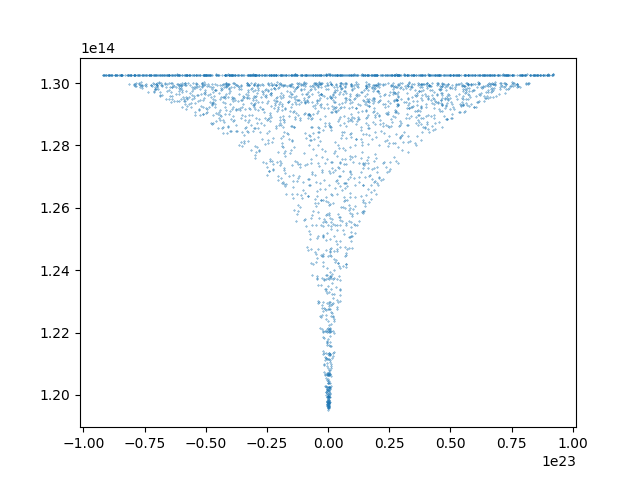

In [39]:
def sum_individual_contributions(mesh, origin, coordinates):
    '''Summing individual contributions of each source linearly'''
    
    #Initialising the sum for the potentials to be 0, then add each contribution to it from each source
    potential_off_center = 0
    
    #Setting the distances to be from the origin so we have the same coordinates for all individual potential
    #and we can coherently add them together
    V, vertex_number, x_coords, y_coords, z_coords, r_coords, sorting_index, x_sorted, y_sorted, z_sorted, r_sorted = rearrange_mesh_data(mesh, origin)
    
    #Assigning each coordinate from the array given as input
    coordinates_x = coordinates[:,0]
    coordinates_y = coordinates[:,1]
    coordinates_z = coordinates[:,2]
    
    #Summing over each source
    for i in range(len(coordinates_x)):
    
        #Defining the potential with respect to a displaced source, but with the usual coordinates
        potential_off_center += (sqrt(G*source_mass*a0)*1/2*np.log((x_coords-coordinates_x[i])**2+
                    (y_coords-coordinates_y[i])**2 + (z_coords-coordinates_z[i])**2))
    
    return potential_off_center

potential_individual_sum = sum_individual_contributions(mesh, origin, random_coordinates)

type(potential_individual_sum)

plt.figure()

# plt.scatter(x_coords, potential_individual_sum, s = 0.1)
plt.scatter(x_coords, potential, s=0.1)


<IPython.core.display.Javascript object>


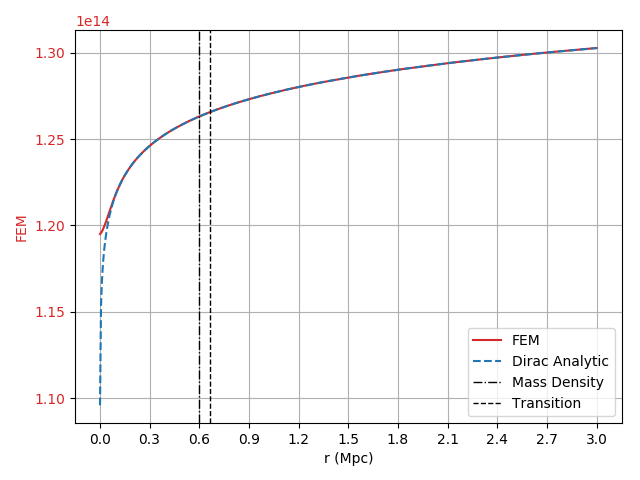

In [40]:
radial_plots_start = time.time()

#Defining analytic functions to check if the result is correct
#2nd argument of Heaviside is its value where the Heaviside goes from 0 to 1
potential_sphere_analytic = (np.heaviside(r_sorted - radius_tot, 0.5)*sqrt(G*mgb*a0)*np.log(r_sorted) +
(np.heaviside(radius_tot - r_sorted, 0.5))*(4/3*sqrt(pi/3*a0*G*mgb/volume_out)*np.power(r_sorted,3/2)+
sqrt(G*mgb*a0)*ln(radius_tot) - 4/3*sqrt(pi/3*a0*G*mgb/volume_out)*radius_tot**(3/2)))

#Analytic potential on the inside of a sphere
potential_inside_analytic = (4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*np.power(r_sorted,3/2)+
sqrt(G*mgb*a0)*ln(radius_tot) - 4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*radius_tot**(3/2))

#Analytic potential for a Dirac Delta
potential_dirac_analytic = sqrt(G*mgb*a0)*np.log(r_sorted)

#Analytic potential for multiple sources (scales with sqrt(#masses))
potential_multiple_dirac_analytic = sqrt(G*mgb*a0/source_number)*np.log(r_sorted)

#Analytic potentials for isothermal distribution
potential_isothermal_analytic = 2/3*sqrt(G*mgb*a0/6)*np.log(1 + np.power(r_sorted, 3/2)/p**(3/2))

#Plotting radial FEM solution and analytic solution on the same plot. We use subplots so'
#we can put multiple axes on the same plot and plot different scales
fig, potential1 = plt.subplots(sharex=True, sharey=True)

color = 'tab:red'
potential1.set_ylabel('FEM', color=color)

potential1.plot(r_sorted, potential_sorted, label = 'FEM', color=color, linestyle='-')

#Plotting the GEA potential as well
# potential1.plot(r_sorted, potential_GEA_sorted, label = 'FEM_GEA', color='tab:green', linestyle='--', linewidth=0.5)

potential1.tick_params(axis='y', labelcolor=color)

#UNCOMMENT TO HAVE SEPARATE AXES TO COMPARE SHAPES
# potential2 = potential1.twinx()
color = 'tab:blue'
# potential2.set_ylabel('Analytic', color=color)
plt.plot(r_sorted, potential_multiple_dirac_analytic, label = 'Dirac Analytic', linestyle = '--', )
# potential2.plot(r_sorted, potential_sphere_analytic, label = 'Dirac Analytic', linestyle = '--', color=color)

#It is possible to use Latex directly in the labels by enclosing expressions in $$
# plt.ylabel('$\phi$')

plot_annotations(potential1)

#Formatting plot using the function I made
plot_format(potential1,1,1)

## Finding the error in the potential, radially

<IPython.core.display.Javascript object>


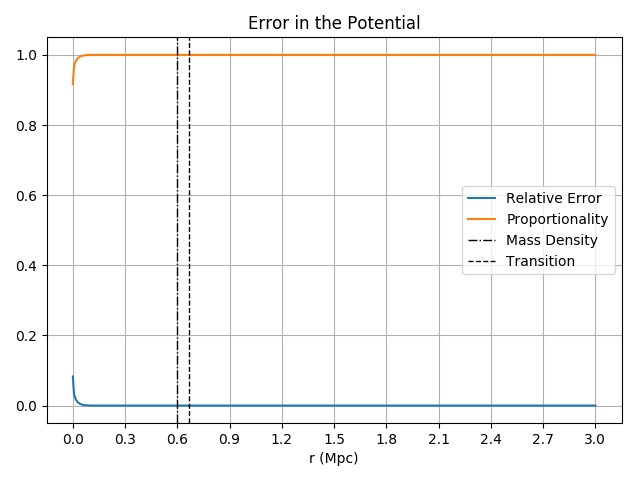

In [41]:
#for spherically symmetric mass distributions we have the anlytic solution, so we can compute
#the error
potential_error = np.abs((potential_sorted - potential_dirac_analytic)/potential_sorted)
potential_proportionality = potential_dirac_analytic/potential_sorted

#plotting the error against the radius
fig, plot_potential_error = plt.subplots(sharex=True, sharey=True)
plot_potential_error.plot(r_sorted,potential_error, label = 'Relative Error')
plot_potential_error.plot(r_sorted,potential_proportionality, label = 'Proportionality')
plt.title('Error in the Potential')
plot_annotations(plot_potential_error)
plot_format(plot_potential_error,1,1)

# Looking at the value of the potential along a specific axis. Useful when dealing with a non-radially symmetric distribution

<IPython.core.display.Javascript object>


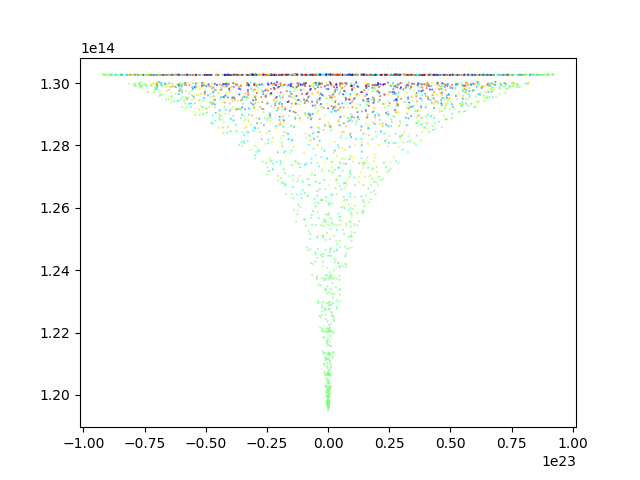

In [42]:
plt.figure()

plt.scatter(x_coords, potential, marker = '.', s = 0.5, c = y_coords/y_coords.max(), cmap = 'jet')


## Next, the acceleration

<IPython.core.display.Javascript object>


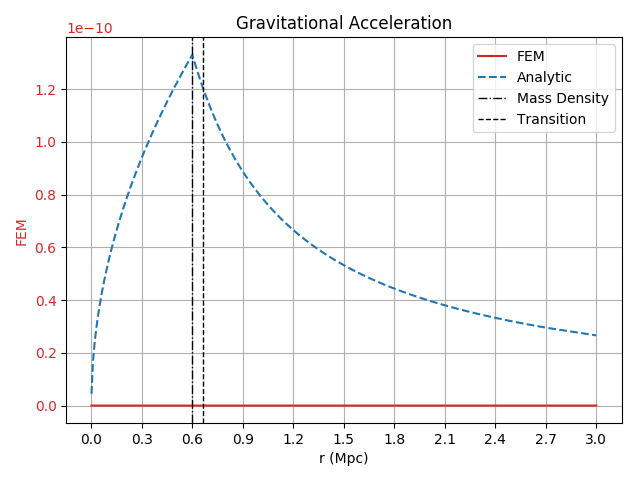

In [43]:
#Defining analytic functions to check if the result is correct
#2nd argument of Heaviside is its value where the Heaviside goes from 0 to 1
acceleration_sphere_analytic = (np.heaviside(r_sorted - radius_tot, 0.5)*sqrt(G*mgb*a0)*1/r_sorted+
(np.heaviside(radius_tot-r_sorted, 0.5))*4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*np.sqrt(r_sorted))

acceleration_dirac_analytic = sqrt(G*mgb*a0)*1/r_sorted

fig, acceleration1 = plt.subplots()

color = 'tab:red'
acceleration1.set_ylabel('FEM', color=color)

acceleration1.tick_params(axis='y', labelcolor=color)

#Plotting radial FEM solution and analytic solution on the same plot
acceleration1.plot(r_sorted, acceleration_magnitude_sorted, label = 'FEM', color = color)

#UNCOMMENT TO HAVE SEPARATE Y AXES
# acceleration2 = acceleration1.twinx()
color = 'tab:blue'
# acceleration2.set_ylabel('Analytic', color=color)

plt.plot(r_sorted, acceleration_sphere_analytic, label = 'Analytic', linestyle = '--', color = color)
plt.title('Gravitational Acceleration')

plot_annotations(acceleration1)

#Formatting plot using the function I made
plot_format(acceleration1,1,1)

## Finding the error in the acceleration

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


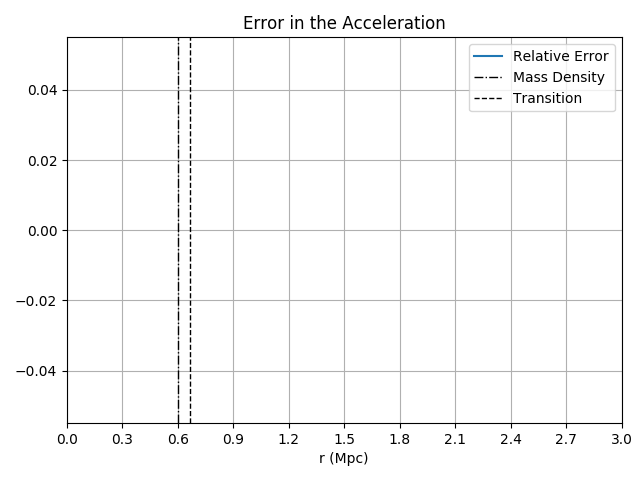

In [44]:
#for spherically symmetric mass distributions we have the anlytic solution, so we can compute
#the error
acceleration_error = np.abs((acceleration_magnitude_sorted - acceleration_dirac_analytic)/acceleration_magnitude_sorted)

#plotting the error against the radius
fig, acceleration_error_plot = plt.subplots()
acceleration_error_plot.plot(r_sorted,acceleration_error, label = 'Relative Error')
plt.title('Error in the Acceleration')
plot_annotations(acceleration_error_plot)
plot_format(acceleration_error_plot,1,1)

## Plotting the actual mass distribution that we input in the PDE, correpsonding to the baryonic matter

<IPython.core.display.Javascript object>


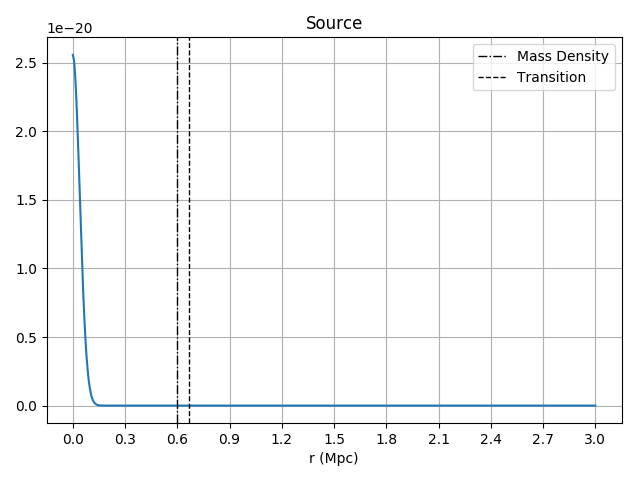

In [45]:
fig, source_radial_plot = plt.subplots()

#Scaling the mass distribution by 4*pi*G to get rho itself
source_radial_plot.plot(r_sorted, 1/(4*pi*G)*source_sorted)

plt.title('Source')
plot_annotations(source_radial_plot)
plot_format(source_radial_plot,1,1)

# Plotting the laplacian of the solution, that for MOND corresponds to the total matter distribution, baryons+dark matter. For Newton it should correspond to the mass distribution that we input in the PDE

<IPython.core.display.Javascript object>


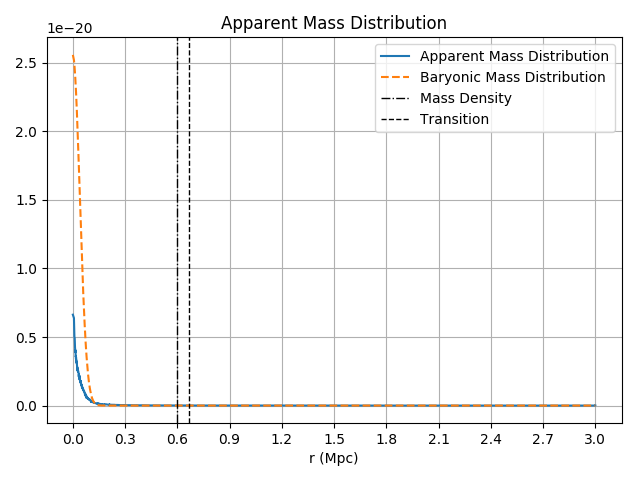

In [46]:
fig, apparent_mass_plot = plt.subplots()

plot_together = True

#Scaling the mass distribution by 4*pi*G to get rho itself
apparent_mass_plot.plot(r_sorted, 1/(4*pi*G)*apparent_mass_distribution_sorted, label = 'Apparent Mass Distribution')

if plot_together == True:
    
    apparent_mass_plot.plot(r_sorted, 1/(4*pi*G)*source_sorted, label = 'Baryonic Mass Distribution', linestyle='--')

plt.title('Apparent Mass Distribution')
plot_annotations(apparent_mass_plot)
plot_format(apparent_mass_plot,1,1)

# Plotting the difference between the apparent mass distribution obtained as the Laplacian of the solution, and the baryonic mass distribution which is the RHS of the PDE

<IPython.core.display.Javascript object>


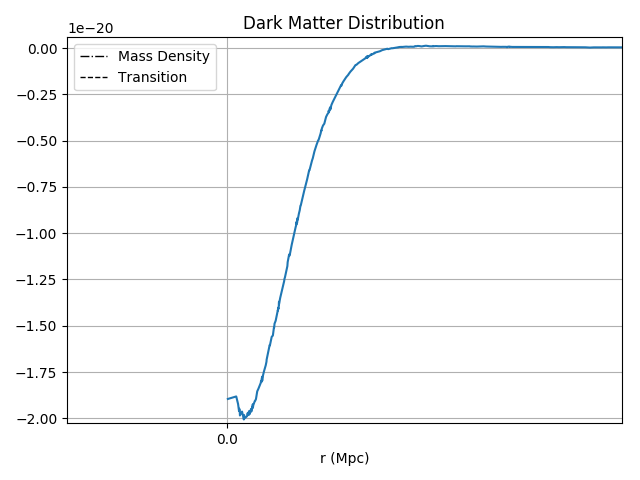

In [47]:
#The difference between apparent mass and baryonic mass is the dark matter distribution
dark_matter_density_sorted = (apparent_mass_distribution_sorted-source_sorted)

fig, dark_matter_density_plot = plt.subplots()

dark_matter_density_plot.plot(r_sorted, 1/(4*pi*G)*dark_matter_density_sorted)
plt.title('Dark Matter Distribution')
plot_annotations(dark_matter_density_plot)
plot_format(dark_matter_density_plot,1,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


<IPython.core.display.Javascript object>


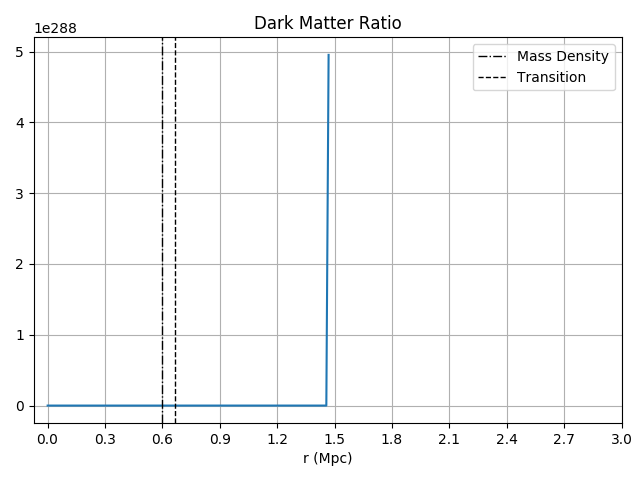

In [48]:
#The ratio between apparent mass and baryonic mass is the dark matter distribution
dark_matter_ratio_sorted = (apparent_mass_distribution_sorted/source_sorted)

fig, dark_matter_ratio_plot = plt.subplots()

dark_matter_ratio_plot.plot(r_sorted, dark_matter_ratio_sorted)
plt.title('Dark Matter Ratio')
plot_annotations(dark_matter_ratio_plot)
plot_format(dark_matter_ratio_plot,1,1)

## Histogram to look at the radial vertex distribution
### First, defining the function to do this

In [49]:
def radial_dist_hist(mesh, density, bins):
    
    #Having independent y axes so we don't need to adjust the function to compare the scaling 
    fig, histo = plt.subplots()
    color = 'tab:blue'
    histo.set_ylabel('radial distance density', color=color)
    histo.tick_params(axis='y', labelcolor=color)
    
    #Looking at how the points are distributed radially. If they are uniform, their density
    #should increase with r^2 due to sphere surface
    #plotting histogram of point density radially
    to_hist = histo.hist(r_coords, density=density, bins=bins, label = 'distribution', color = color)
    
    #Adding the value of each bin on top of the bin
    for i in range(bins):
        plt.text(to_hist[1][i],to_hist[0][i],str(int(to_hist[0][i])))
    
    #Putting the grid with the histogram values as those are the interesting quantities
    plt.grid()
    
    #Second y axis
    quadratic = histo.twinx()
    color = 'tab:orange'
    quadratic.set_ylabel('Quadratic', color=color)
    quadratic.tick_params(axis='density', labelcolor=color)
    
    #plotting a cubic relation, scaled by the max element^3 to be of order unity
    quadratic.plot(r_sorted, np.power(r_sorted,2), label = 'quadratic', color = color)
    
    #Forcing the lower limit in both plots to 0 so there's no offset
    plt.ylim(bottom=0)
    
    plt.tight_layout()
    plt.legend()

### Applying the function to the generated mesh

<IPython.core.display.Javascript object>


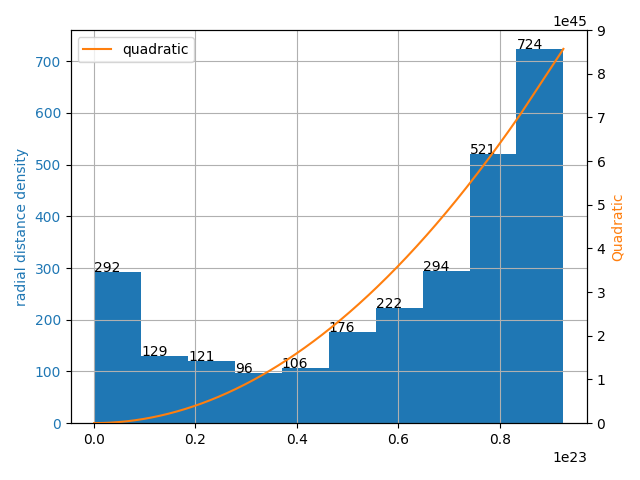

In [50]:
radial_dist_hist(mesh, False, 10)

radial_plots_end = time.time()
radial_plots_time = run_time(radial_plots_start - radial_plots_end, 'Radial Plots')
# section_times.append(radial_plots_time)

## For non spherically symmetric meshes, and for visual clarity, taking a slice of the mesh and plotting it in 2D

## First, a 3D view of the mesh vertices

In [51]:
def plot_mesh(figure, vertex_fraction, color, show_mesh = False, alpha = 0.3):
    '''
    Plotting the first vertex_number/vertex_fraction points of the mesh, based on radial
    distance. Need to input a figure name of format figure = plt.figure() for the subplot
    to work. Through this, we can embed this plot into other plots. Adding optional mesh and
    alpha inputs.
    '''
    
    #Getting the number of vertices required as an intege of the fraction given
    how_many = int(vertex_number/vertex_fraction)
    
    #projection='3d' needed to specify a 3D scatter plot
    mesh_scatter = figure.add_subplot(111, projection='3d')
    
    #plotting the total/vertex_fraction closest vertices to the origin
    #s gives the size of the dots, multiplying it by vertex_fraction so when we have less dots
    #we can make them more visible
    (mesh_scatter.scatter(x_sorted[0:how_many], y_sorted[0:how_many], z_sorted[0:how_many],
                         marker = '.', s=1*vertex_fraction, c = color))
    
    #Adding optional to show the mesh at the same time
    if show_mesh:
        plot(mesh, alpha = alpha, color = 'w')
    else:
        pass

<IPython.core.display.Javascript object>


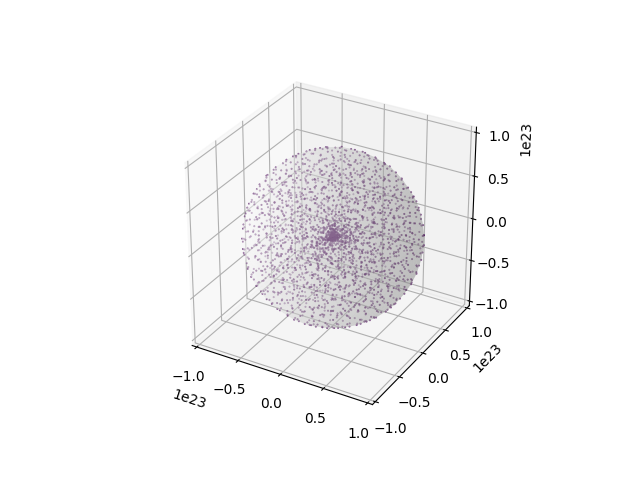

In [52]:
plots_3D_start = time.time()

#Have to first declare a figure and use its name as an input to the function
#This way the plot can be plotted alongside other plots on the same grid
whole_mesh = plt.figure()

#Plotting the points 
plot_mesh(whole_mesh, 1, acceleration_magnitude_sorted, show_mesh=True, alpha = 0.3)

## Obtaining a slice of mesh points close to the xy plane

In [53]:
def slice_mesh(amount, mesh, height = 0, portion = True, values = True, *args):
    '''Selecting only points of the mesh that are close to the xy plane. First, sorting points
    according to their z coordinate, then selecting either amount # of them or a portion of the
    total, dpeending on 'portion'. Optionally output a function args[0] at those points
    '''
    
    #Getting abs(z), distance from xy plane, and getting the index that sorts this new array
    xy_plane_distance = np.abs(z_coords - height)
    
    #index of points sorted by distance from xy plane (absolute value of z coordinate)
    z_sorting_index = xy_plane_distance.argsort()
    
    #x,y,z coordinates of point sorted by distance from xy plane
    z_xy_plane = z_coords[z_sorting_index]
    x_xy_plane = x_coords[z_sorting_index]
    y_xy_plane = y_coords[z_sorting_index]
    
    #If using the portion option, we take all points below a cutoff given by domain_size/amount
    if portion == True:
        
        #counting number of points with xy_plane distance > domain_size/amount
        amount = np.count_nonzero(xy_plane_distance < int(domain_size/amount))
    
    #If not using the portion option, the slice has num_vertices/amount total # points
    else:
        
        amount = int(mesh.num_vertices()/amount)
                
    #The slice has amount # points
    x_xy_plane = x_xy_plane[0:amount]
    y_xy_plane = y_xy_plane[0:amount]
    z_xy_plane = z_xy_plane[0:amount]

    if values == True:
        function_xy_plane = args[0][z_sorting_index]
        function_xy_plane = function_xy_plane[0:amount]
        
        return x_xy_plane, y_xy_plane, z_xy_plane, function_xy_plane, amount
    
    else:
        return x_xy_plane, y_xy_plane, z_xy_plane, amount

In [54]:
def plot_mesh_slice(amount, figure, source_coordinates, height = 0, portion = True, show_mesh = True, cross_section = False, alpha = 0.3, show_source = True):
    '''
    Plotting a slice of points on the mesh close to the xy axis, so for small z.
    Need to create a figure before calling the function. Optional showing mesh on top
    of scatter, True by default, and transparency of mesh set by default to 0.3
    '''
    
    #Calling the slice_mesh function to slice the mesh before plotting
    x_xy_plane, y_xy_plane, z_xy_plane, amount = (slice_mesh(amount, mesh, height = height,
                                                             portion = portion, values = False))
    
    #projection='3d' needed to specify a 3D scatter plot
    mesh_xy_axis = figure.add_subplot(111, projection='3d')
    
    #plotting the total/vertex_fraction closest vertices to the origin
    #s gives the size of the dots, multiplying it by vertex_fraction so when we have less dots
    #we can make them more visible
    (mesh_xy_axis.scatter(x_xy_plane, y_xy_plane, z_xy_plane,
                         marker = '.', s=vertex_number/amount, c = z_xy_plane))
    
    #Plotting the source(s) on top of the mesh points, to check if we refine mesh correctly
    if show_source == True:
        
        (mesh_xy_axis.scatter(random_coordinates[:,0],random_coordinates[:,1],
        random_coordinates[:,2], marker = 'o', s=vertex_number/amount*5, c = 'r', label='Source'))
            
    
    #Projecting each point on the xy plane, at z=0 (zs=0)
    mesh_xy_axis.plot(x_xy_plane, y_xy_plane, 'b+', zdir='z', zs=height, label = 'xy-plane projection')
    
    mesh_xy_axis.legend()
    
    #Adding optional to show the mesh at the same time
    if show_mesh:
        plot(mesh, alpha = alpha, color = 'w')
    else:
        pass
    
    #Option to plot the cross section, color coded by distance from xy plane
    if cross_section:
        plt.figure()
        plt.scatter(x_xy_plane, y_xy_plane, c = z_xy_plane, marker = '+')
        
        if show_source:
            (plt.scatter(random_coordinates[:,0],random_coordinates[:,1], marker = 'o',
            color = 'r', s=vertex_number/amount*5))
        
    else:
        pass

<IPython.core.display.Javascript object>


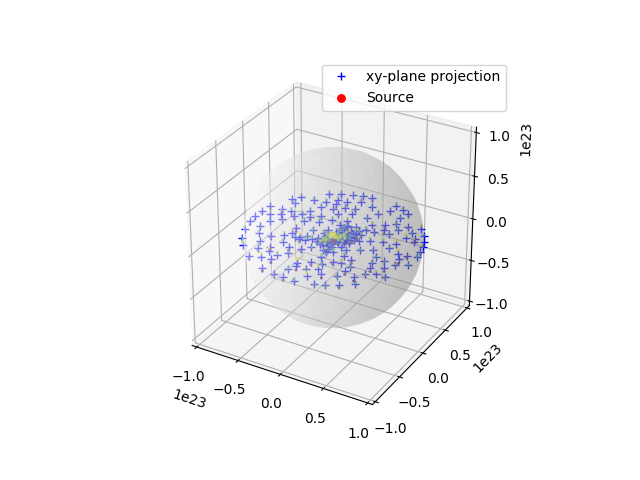

<IPython.core.display.Javascript object>


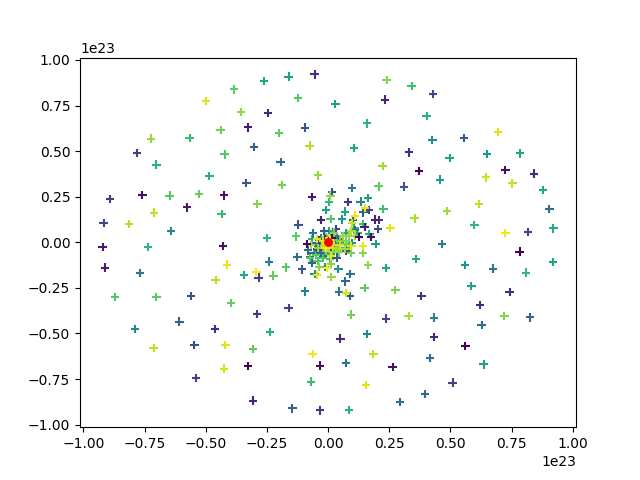

In [55]:
mesh_plane = plt.figure()
plot_mesh_slice(20, mesh_plane, random_coordinates, height = center_of_mass_z, portion = True, cross_section=True, show_source=True)

## Defining a function to plot a trisurf graph of a slice of the domain, here the xy axis

In [56]:
def trisurf_function_slice(figure, function, amount, height, slices = 50, high_low = 'low', project = True):
    '''Plot a trisurf along a plane (currently only the xy-plane) of a given function. The slice
    of points defining the xy plane is obtained from the slice_mesh function. Then, project
    the triangulated surface onto each axis if optional arg project = True. high_low determines
    whether to project the xy plane contour above or below surface
    '''
    
    #Obtaining the x,y coordinates and functions to plot from slice_mesh
    x_xy_plane, y_xy_plane, z_xy_plane, function_xy_plane, amount = (slice_mesh(amount,
                                            mesh, height, True, True, function))
    
    #Adding a subplot to the figure input
    plane_trisurf = figure.add_subplot(111, projection='3d')
    
    #Plotting the trisurf (triangulated surface) on the plane
    plane_trisurf.plot_trisurf(x_xy_plane, y_xy_plane, function_xy_plane, cmap = 'jet')
    
    #Setting the x and y limits to leave some space for the contours to be clearer
    x_bottom, x_top = plt.xlim(-domain_size*1.2, domain_size*1.2) 
    y_bottom, y_top = plt.ylim(-domain_size*1.2, domain_size*1.2) 
    
    #Setting the z limit conditionally, based on the function being increasing or decreasing
    if high_low == 'high':
        z_limit = function.max()
    
    else:
        z_limit = function.min()
    
    #If project = True, project contours on each axis
    if project:
    
        #Projecting contours of the surface in each cartesian direction using zdir and offset
        #for direction and offset from the axes origins respectively
        plane_trisurf.tricontourf(x_xy_plane, y_xy_plane, function_xy_plane, slices, zdir='z', offset=z_limit, cmap = 'jet')
        plane_trisurf.tricontourf(x_xy_plane, y_xy_plane, function_xy_plane, slices, zdir='x', offset=y_bottom, cmap = 'jet')
        plane_trisurf.tricontourf(x_xy_plane, y_xy_plane, function_xy_plane, slices, zdir='y', offset=x_top, cmap = 'jet')

In [57]:
if plot_3D_graphs:

    trisurf_potential = plt.figure()
    trisurf_function_slice(trisurf_potential, potential, 20, center_of_mass_z)
    plt.title('Potential in xy-plane')

In [58]:
if plot_3D_graphs:  
    
    trisurf_acceleration = plt.figure()
    trisurf_function_slice(trisurf_acceleration, acceleration_magnitude, 20, center_of_mass_z, high_low = 'high')
    plt.title('Acceleration in xy-plane')

In [59]:
# trisurf_source = plt.figure()
# trisurf_function_slice(trisurf_source, source, 20, center_of_mass_z, high_low = 'high')
# plt.title('Source in xy-plane')

## Plotting contour lines of the potential, so we can do that for different values of z and see the whole domain.

In [60]:
def tricontour_function_slice(figure, function, amount, levels, height):
    '''Plot a trisurf along a plane (currently only the xy-plane) of a given function. The slice
    of points defining the xy plane is obtained from the slice_mesh function
    '''
    
    #Obtaining the x,y coordinates and functions to plot from slice_mesh
    x_xy_plane, y_xy_plane, z_xy_plane, function_xy_plane, amount = (slice_mesh(amount,
                                            mesh, height, True, True, function))
    
    #Adding a subplot to the figure input. Not adding the projection = 3d option so we have it 
    #all in one plane and can plot multiple for e.g. different values of z
    plane_tricontour = figure.add_subplot(111)
    
    #Defining the levels of the contour to be between the max and min value of the function
    #in 'levels' homogeneous steps
    contour_levels = np.linspace(function.min(), function.max(), levels)
    
    #Plotting the contour
    plane_tricontour.tricontour(x_xy_plane, y_xy_plane, function_xy_plane, contour_levels, cmap = 'jet')
    plane_tricontour.set_aspect('equal', 'box')

<IPython.core.display.Javascript object>


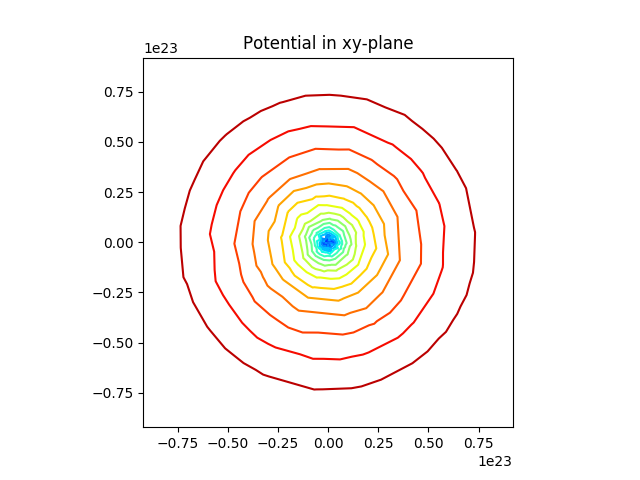

Text(0.5, 1.0, 'Potential in xy-plane')

In [61]:
tricontour_potential = plt.figure()
tricontour_function_slice(tricontour_potential, potential, 20, 20, center_of_mass_z)
plt.title('Potential in xy-plane')

<IPython.core.display.Javascript object>


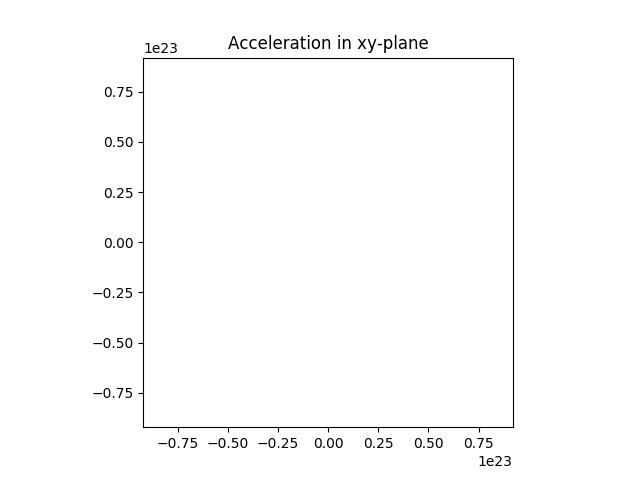

/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0.5, 1.0, 'Acceleration in xy-plane')

In [62]:
trisurf_acceleration = plt.figure()
tricontour_function_slice(trisurf_acceleration, acceleration_magnitude, 20, 20, center_of_mass_z)
plt.title('Acceleration in xy-plane')

<IPython.core.display.Javascript object>


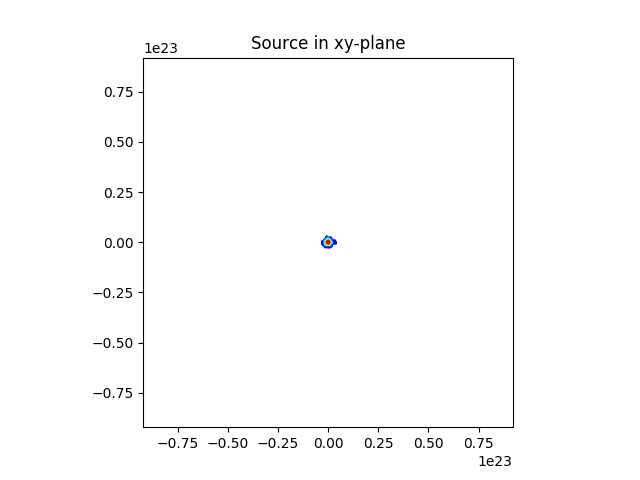

Text(0.5, 1.0, 'Source in xy-plane')

In [63]:
trisurf_source = plt.figure()
tricontour_function_slice(trisurf_source, source, 20, 20, center_of_mass_z)
plt.title('Source in xy-plane')

## Making a function to plot slices and view them in 3D
### The 2 cells below this on contain the call to the function

In [64]:
def contour_3D_slices(figure, function, amount, height, slices = 50, high_low = 'low'):
    
    #Adding a subplot to the figure input
    plane_trisurf = figure.add_subplot(111, projection='3d')

    #Setting the x and y limits to leave some space for the contours to be clearer
    x_bottom, x_top = plt.xlim(-domain_size*1.2, domain_size*1.2) 
    y_bottom, y_top = plt.ylim(-domain_size*1.2, domain_size*1.2) 
#     z_bottom, z_top = Axes3D.zlim(-domain_size*1.2, domain_size*1.2) 
    
    #Setting the z limit conditionally, based on the function being increasing or decreasing
    if high_low == 'high':
        z_limit = function.max()
    
    else:
        z_limit = function.min()
    
    #Obtaining a range of n values for both the function and the domain (from min to max)
    function_to_loop = np.linspace(function.min(), function.max(), 11)
    height_to_loop = np.linspace(-domain_size*0.9, domain_size*0.9, 11)
    
    #Stacking the two ranges together so we can loop over them, and transpose so that each
    #element of the array is a pair of corresponding function value-domain location
    total_to_loop = np.vstack((function_to_loop, height_to_loop))
    total_to_loop = np.transpose(total_to_loop)
    
    #Looping over the function-domain slice pairs
    for elevations in total_to_loop:
        
        #IMPORTANT! For this loop to work, we need to have the same #function points for each
        #slice. So we need to set the portion option from slice_mesh to False, so it takes
        #the same #points every time, and not whatever number is within the given range
        #Obtaining the x,y coordinates and functions to plot from slice_mesh
        x_xy_plane, y_xy_plane, z_xy_plane, function_xy_plane, amount = (slice_mesh(amount,
                                                mesh, elevations[1], False, True, function))

        #Projecting contours of the surface in each cartesian direction using zdir and offset
        #for direction and offset from the axes origins respectively
        plane_trisurf.tricontourf(x_xy_plane, y_xy_plane, function_xy_plane, slices, zdir='z', offset=elevations[0],cmap = 'jet')
    #     plane_trisurf.tricontourf(x_xy_plane, y_xy_plane, function_xy_plane, slices, zdir='x', offset=y_bottom, cmap = 'jet')
    #     plane_trisurf.tricontourf(x_xy_plane, y_xy_plane, function_xy_plane, slices, zdir='y', offset=x_top, cmap = 'jet')

In [65]:
#IMPORTANT: Right now, using a predefined amount of contours for each level, but this means
#that the colors ar enot consistent between different levels! So want to change it that instead
#of a numebr of contours, we have contours at specific values! That way the plot makes sense,
#and it will also look like a sphere since the max potential will be at the boundary, which 
#becomes smaller for each level.

# potential_slices = plt.figure()

# contour_3D_slices(potential_slices, potential, 100, 0)

In [66]:
# acceleration_slices = plt.figure()

# contour_3D_slices(acceleration_slices, acceleration_magnitude, 100, 0)

In [67]:
# source_slices = plt.figure()

# contour_3D_slices(source_slices, source, 100, 0)

## Looking at a quiver plot of the acceleration (useful when having multiple masses)

<IPython.core.display.Javascript object>


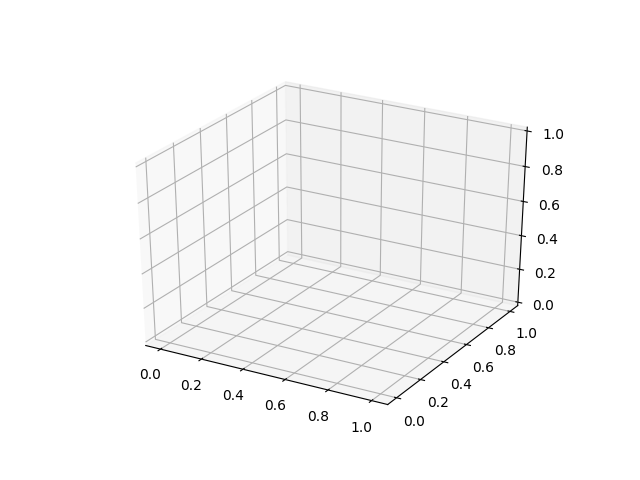

In [68]:
figure = plt.figure()

quivers = figure.add_subplot(111, projection='3d')

quivers.quiver(x_coords, y_coords, z_coords, acceleration_x, acceleration_y, acceleration_z, length=domain_size, normalize = False)


In [69]:
plots_3D_end = time.time()
plots_3D_time = run_time(plots_3D_end - plots_3D_start, '3D Plots')
section_times.append(plots_3D_time)

## Plotting the times taken by each section to profile the code

<IPython.core.display.Javascript object>


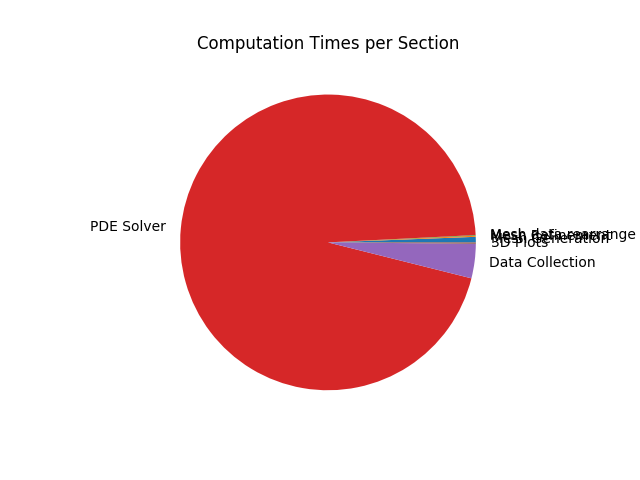

Text(0.5, 1.0, 'Computation Times per Section')

In [70]:
plt.figure()
pie_name = [section.name for section in section_times]
pie_time = np.zeros((len(section_times),1))

#can't use a list comprehension as for pie_name to make a numpy array, cause it makes
#a list instead! and for numbers it's always best to work with numpy 
for i, section in enumerate(section_times):
    pie_time[i] = section.time
    
#percentage of time taken, to display on the pie chart
pie_time_percent = [pie_time/(pie_time.sum()*100)]

#plotting the pie chart
plt.pie(pie_time, labels = pie_name)
# plt.legend()
plt.title('Computation Times per Section')

In [71]:
print('Overall time taken: {} s \n'.format(time.time() - starting_time))

Overall time taken: 254.96574759483337 s 



In [72]:
#Uncomment to close all figures so it doesnt take up all the memory
# plt.close('all')

# Other instance of main solver to either compare solutions or explore parameter space etc.

## First, we compare the three interpolation functions (deep, simple, standard) for some different mass distributions.

In [73]:
def compare_solutions(PDE_List, max_value, variable_name, samples, variable_title, title_units):
    '''This function accepts a list of BVP object, containing weak form, source, initial guess
    and name for a given BVP. Max value is the maximum value of a variable that is to be analysed,
    and looped over, variable_name is its name, samples is the amount of values to be taken between
    zero and max_value when looping over the variable, and variable_title is used to name subplots'''
    
    print(f'{variable_name} = {eval(variable_name)}')
    
    #Defining the amount of subplots needed from the samples input. We want samples/2 columns, and 2 rows
    #For it to work for odd numbers, we add the remainder of 2 so it's always divisible, then convert
    #to integer
    subplot_layout = (int((samples+samples%2)/2),2)
    
    #If we have only one sample, we make a plot with no subplots.
    if samples == 1:
    
        fig, potential_compare = (plt.subplots(sharex=True,sharey=True))
    
    else: 
        
        # Making a figure before we loop so all plots go in the same one. Sharing x,y axes per column/row
        #and getting rid of space inbetween graphs
        fig, potential_compare = (plt.subplots(subplot_layout[0],subplot_layout[1],sharex=True,sharey=True))
    #                                           gridspec_kw={'hspace': 0, 'wspace': 0}))
    
    #Defining an empty list to hold the solutions of each PDE, with #elements equal to samples
    u_list = [0 for sample in range(len(PDE_List))]

    #Defining a list of the potentials from the solution from each weak form
    potential_list = u_list

    #List for the sorted potentials
    potential_sorted_list = u_list
    
    #We loop over the chosen variable, going from its max_value/sample number to its max value
    for j, variable_value in enumerate(np.linspace(1,samples,samples)*max_value/samples):
        
        #Assigning the value of variable_value to the variable (e.g. standard deviation, #source etc.)
        #We need to evaluate it from here through te variable name in order for it to correctly pass it
        #to the c++ code in the solver. {variable name}. Must use exec, not eval for assignment
        exec(f'{variable_name} = {variable_value}')
        
        print(f'{variable_name} = {eval(variable_name)}')
        
        #If there are two or fewer subplots, the subplot index must actually be a number, not a tuple.
        #Either 0 or 1, so same as j.
        if samples <= 2:

            subplot_index = j
        
        else:
        
            #Converting the index i to binary, then using it to indicate the subplots to use [0,0], [0,1]
            # and so on
            subplot_index = ((int(j/2), j%2))
        
        #Looping over weak forms for the same initial guess and source
        for i, PDE in enumerate(PDE_List):
            
            #Putting the solutions in the u_list list
            u_list[i], f = solve_PDE(PDE)

            #Getting the potentials and sorted potentials for each solution
            potential_list[i] = u_list[i].compute_vertex_values()
            potential_sorted_list[i] = potential_list[i][sorting_index]
            
            #If we have the Newtonian potential, we add the difference at the boundary so they are on the
            #same part of the plot. Doesnt matter that we add a constant to the potential anyway
            if 'Newton' in PDE.name:
                
                potential_sorted_list[i] = (potential_sorted_list[i] + sqrt(G*mgb*a0)*ln(domain_size))
            
            #If we have only one sample, we plot on the plot itself, not a subplot
            if samples == 1:
                
                #Plot all the potentials on the same graph
                potential_compare.plot(r_sorted, potential_sorted_list[i], label = PDE.name)
            
            else:
            
                #Plot all the potentials on the same graph
                potential_compare[subplot_index].plot(r_sorted, potential_sorted_list[i], label = PDE.name)
        
        #Making a string for the title of each plot. The :.2E is to format the number in the title to be
        #in powers of 10.
        plot_title = f'${variable_title} = {(int(variable_value)):.1E} \: {title_units}$'
        
        #If we have only 1 sample, we need to call the function for the plot, rather than subplot
        if samples == 1:
        
            #Giving a title to each subplot
            potential_compare.set_title(plot_title)

            #Formatting each subplot after it's been filled with all the curves
            plot_format(potential_compare,1,1)
        
        else:

            potential_compare[subplot_index].set_title(plot_title)

            plot_format(potential_compare[subplot_index],1,1)
        
    return u_list, potential_sorted_list

In [74]:
#Lists of same source, different weak form.
BVP_dirac_list = [newton_dirac, mond_deep_dirac, mond_simple_dirac, mond_standard_dirac]
BVP_gauss_list = [newton_gauss, mond_deep_gauss, mond_simple_gauss, mond_standard_gauss]
BVP_continuous_list = [newton_continuous, mond_deep_continuous, mond_simple_continuous, mond_standard_continuous]

#list of same weak form, different source.
BVP_deep_list = [mond_deep_dirac, mond_deep_gauss, mond_deep_continuous]
BVP_simple_list = [mond_simple_dirac, mond_simple_gauss, mond_simple_continuous]
BVP_standard_list = [mond_standard_dirac, mond_standard_gauss, mond_standard_continuous]
BVP_newton_list = [newton_dirac, newton_gauss, newton_continuous]

if make_comparison:

    #Running the compare function
    discrete_list = compare_solutions(BVP_dirac_list, stand_dev, 'stand_dev', 1, '\sigma = ', 'Mpc')

In [75]:
BVP_continuous_list[2].source

'4*pi*G*pow(2*pi,-1.5)*source_mass/pow(stand_dev,3)*exp(-(pow(x[0],2) + pow(x[1],2) + pow(x[2],2))/(2*(pow(stand_dev,2))))'

In [76]:
samples = 1

subplot_layout = (int((samples+samples%2)/2),2)